# Database Design for Recommender Systems

The python code given below measures the performance of 5 different database types i.e. Postgres, Mongodb, Cassandra, Redis and Neo4j. Measurement of performance is done on 2 dataset namely Retail Rocket (events.csv) and Diginetica (train_clicks.csv).

Operations performed to measure performance - 
- 1. Creation of Database based on Dataset Features
- 2. Inserting Records into Created Database (Bulk Insertion & Batch Insertion) 
- 3. Reading Records
- 4. Updating Records
- 5. Deleting Records 

Apart from this, A Neo4j Graph Based Recommender System is also developed using movielens dataset.

Operations performed for creating Neo4j Graph Based Recommender System - 
- 1. Creating Nodes and Relationships
- 2. Movie-Movie Similarity 
- 3. Jaccard Similarity 
- 4. Getting Recommendations

## 1. Importing Libraries

In [ ]:
import time
import psycopg2
import pymongo
import redis
from neo4j import GraphDatabase
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import matplotlib.pyplot as plt
import pandas as pd
import psutil
import threading
from queue import Queue
import numpy as np
import seaborn as sns

## 2. Exploratory Data Analysis

### 2.1. Retail Rocket Dataset

In [4]:
import pandas as pd
retail_data = pd.read_csv('events.csv')
retail_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [7]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [9]:
retail_data.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


### 2.2. Diginetica Dataset

In [6]:
diginetica_data = pd.read_csv('train-clicks.csv')
diginetica_data.head()

,queryid,timeframe,itemid
0,1,16338861,24857
1,46255,16404912,30792
2,46689,3831948,8252
3,46731,16273568,33969
4,46748,4058493,7837


In [8]:
diginetica_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   queryid    1048575 non-null  int64
 1   timeframe  1048575 non-null  int64
 2   itemid     1048575 non-null  int64
dtypes: int64(3)
memory usage: 24.0 MB


In [10]:
diginetica_data.describe()

,queryid,timeframe,itemid
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.712313e+05,6.870547e+07,7.588660e+04
std,2.669819e+05,5.407823e+08,9.644660e+04
min,1.000000e+00,6.680000e+02,2.000000e+00
25%,2.429610e+05,7.212250e+04,1.304300e+04
50%,4.659860e+05,2.899920e+05,3.665900e+04
75%,6.894725e+05,1.204110e+06,8.849500e+04
max,9.805000e+05,1.278077e+10,7.310410e+05


## 3. Retail Rocket Dataset

### 3.1. Creating Retail Rocket Database

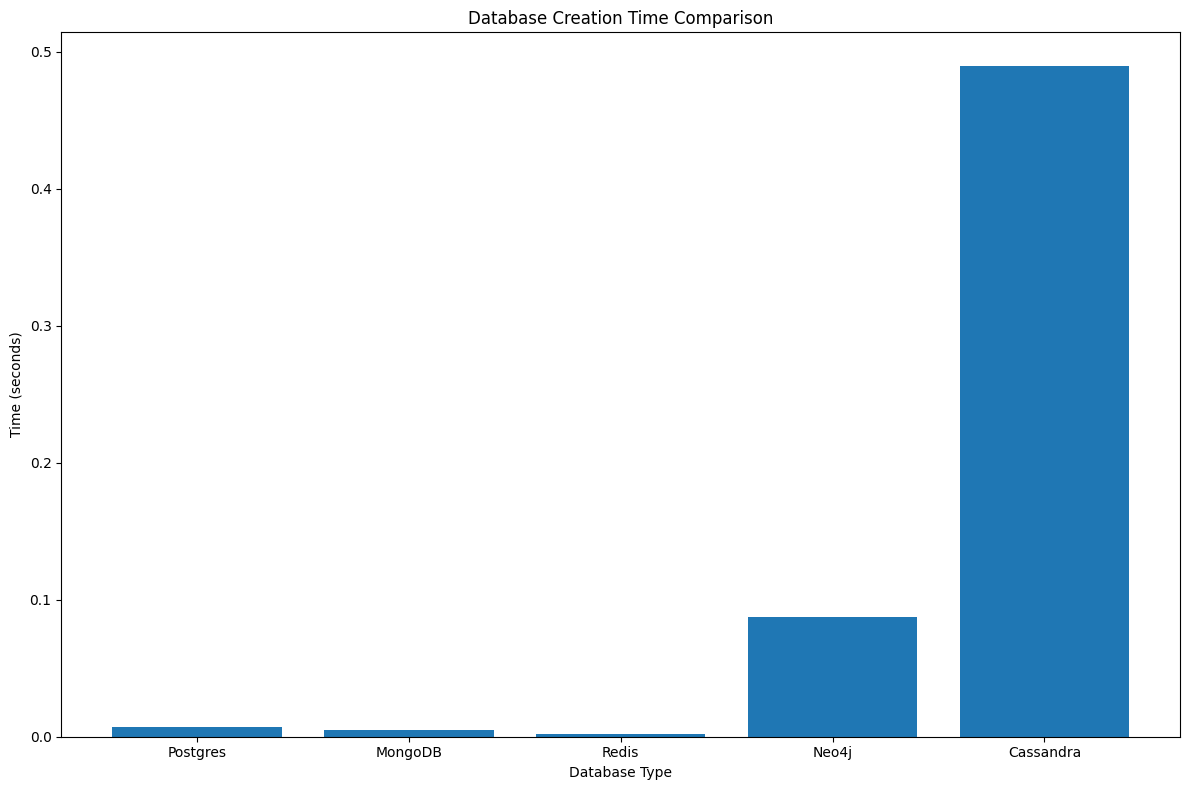

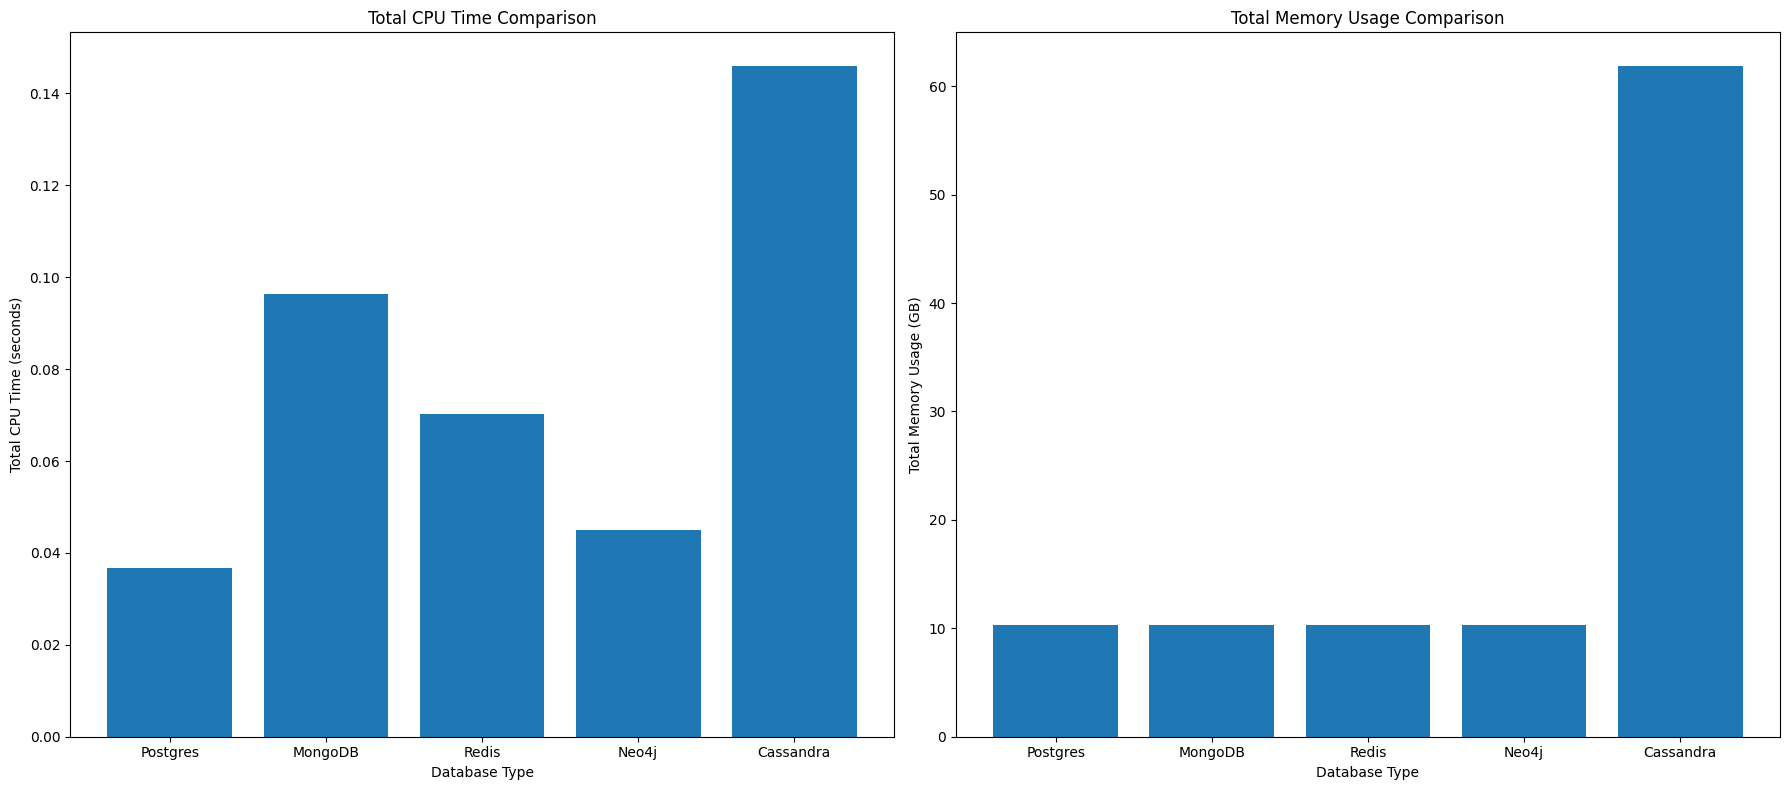

In [53]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Postgres: Create database
def create_postgres(db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute("DROP TABLE IF EXISTS events;")
    cur.execute("""
    CREATE TABLE events (
        timestamp BIGINT,
        visitorid BIGINT,
        event TEXT,
        itemid BIGINT,
        transactionid BIGINT
    );
    """)
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Create database
def create_mongodb(db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    collection.drop()
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Create database
def create_redis():
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    redis_client.flushdb()
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Create database
def create_neo4j(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    session.run("MATCH (n) DETACH DELETE n")
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Create database
def create_cassandra(keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    session.execute(f"DROP KEYSPACE IF EXISTS {keyspace}")
    session.execute(f"CREATE KEYSPACE {keyspace} WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}}")
    session.execute(f"""
    CREATE TABLE {keyspace}.{table} (
        timestamp bigint PRIMARY KEY,
        visitorid bigint,
        event text,
        itemid bigint,
        transactionid bigint
    );
    """)
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'retailrocket',
    'table': 'events'
}

results = {'Postgres': {'time': [], 'cpu': [], 'memory': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': []},
           'Redis': {'time': [], 'cpu': [], 'memory': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': []}}

# Create databases and measure time, CPU, and memory usage
time_taken, cpu_time, memory_usage = create_postgres(db_params)
results['Postgres']['time'].append(time_taken)
results['Postgres']['cpu'].append(cpu_time)
results['Postgres']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_mongodb('retailrocket', 'events')
results['MongoDB']['time'].append(time_taken)
results['MongoDB']['cpu'].append(cpu_time)
results['MongoDB']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_redis()
results['Redis']['time'].append(time_taken)
results['Redis']['cpu'].append(cpu_time)
results['Redis']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_neo4j(**neo4j_params)
results['Neo4j']['time'].append(time_taken)
results['Neo4j']['cpu'].append(cpu_time)
results['Neo4j']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_cassandra(**cassandra_params)
results['Cassandra']['time'].append(time_taken)
results['Cassandra']['cpu'].append(cpu_time)
results['Cassandra']['memory'].append(memory_usage)

# Save results to CSV
df_results = pd.DataFrame({
    'Database': ['Postgres', 'MongoDB', 'Redis', 'Neo4j', 'Cassandra'],
    'Time (s)': [results['Postgres']['time'][0], results['MongoDB']['time'][0], results['Redis']['time'][0], results['Neo4j']['time'][0], results['Cassandra']['time'][0]],
    'CPU Time (s)': [results['Postgres']['cpu'][0], results['MongoDB']['cpu'][0], results['Redis']['cpu'][0], results['Neo4j']['cpu'][0], results['Cassandra']['cpu'][0]],
    'Memory Usage (GB)': [results['Postgres']['memory'][0] / 1024, results['MongoDB']['memory'][0] / 1024, results['Redis']['memory'][0] / 1024, results['Neo4j']['memory'][0] / 1024, results['Cassandra']['memory'][0] / 1024]
})
df_results.to_csv('database_creation_results.csv', index=False)

# Plotting Database Creation Time Comparison
fig1, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(df_results['Database'], df_results['Time (s)'])
ax1.set_xlabel('Database Type')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Database Creation Time Comparison')
ax1.grid(False)

plt.tight_layout()
plt.savefig('database_creation_time_comparison.png')
plt.show()

# Plotting Total CPU Time and Memory Usage side by side
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting total CPU time
ax2.bar(df_results['Database'], df_results['CPU Time (s)'])
ax2.set_xlabel('Database Type')
ax2.set_ylabel('Total CPU Time (seconds)')
ax2.set_title('Total CPU Time Comparison')
ax2.grid(False)

# Plotting total memory usage
ax3.bar(df_results['Database'], df_results['Memory Usage (GB)'])
ax3.set_xlabel('Database Type')
ax3.set_ylabel('Total Memory Usage (GB)')
ax3.set_title('Total Memory Usage Comparison')
ax3.grid(False)

plt.tight_layout()
plt.savefig('cpu_ram_comparison_creation.png')
plt.show()


### 3.2. Inserting Records into Retail Rocket Database

##### 3.2.1. Bulk Insertion in Retail Rocket Database

/tmp/ipykernel_2517/3359885767.py:97: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/3359885767.py:97: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/3359885767.py:97: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/3359885767.py:97: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/3359885767.py:97: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/3359885767.py:97: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict()

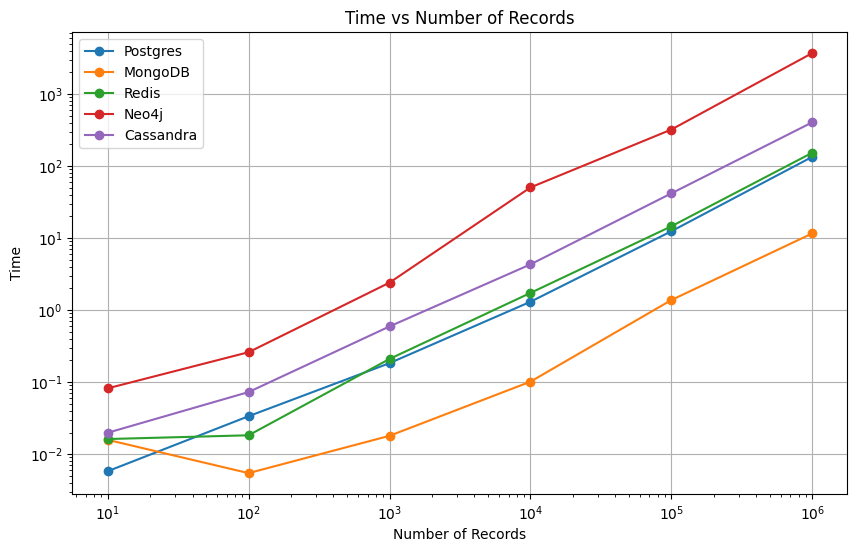

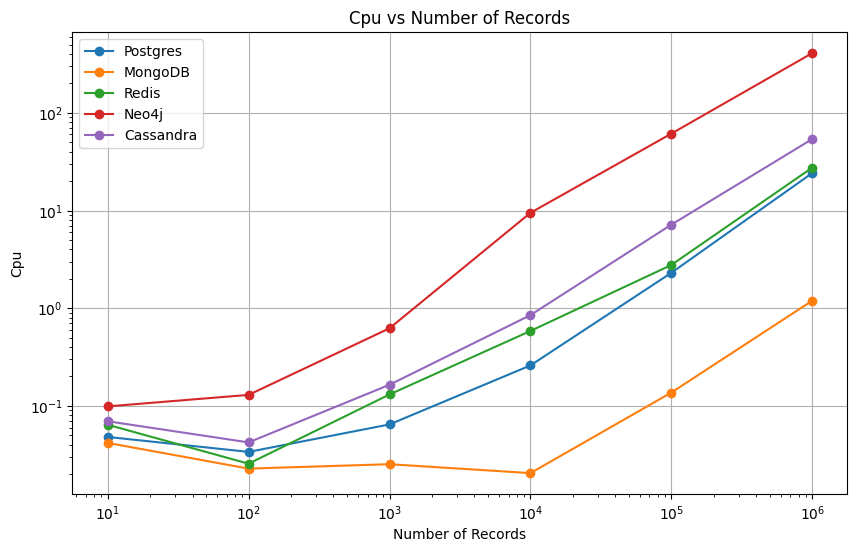

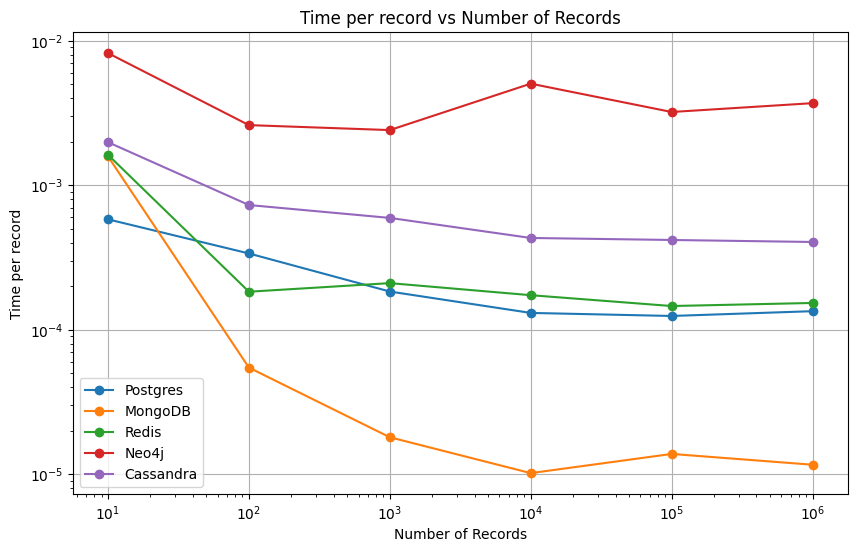

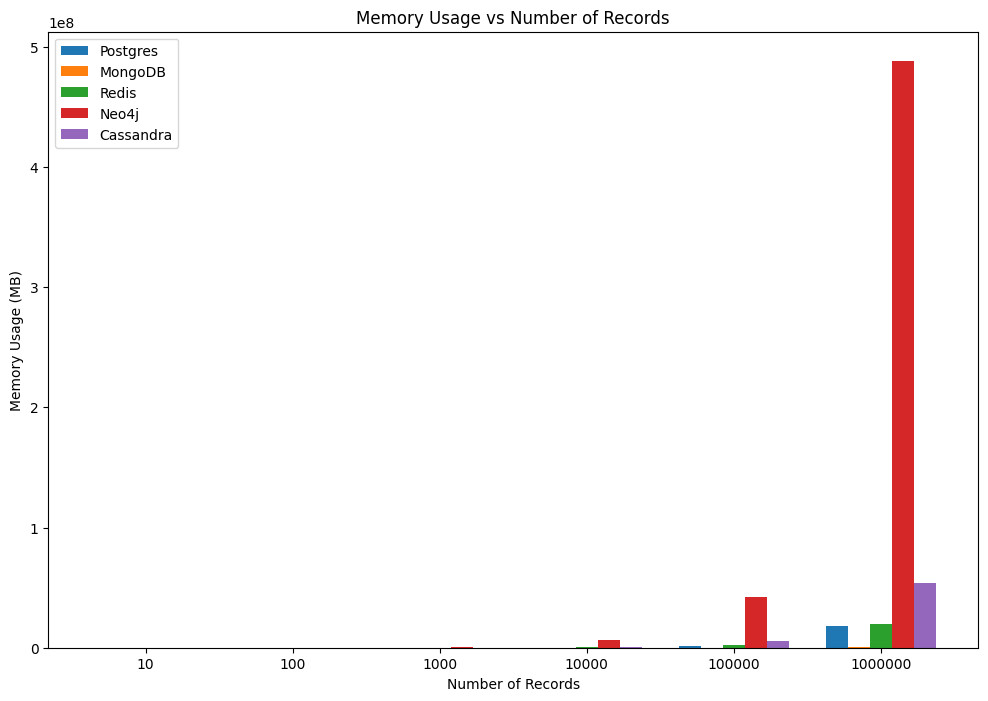

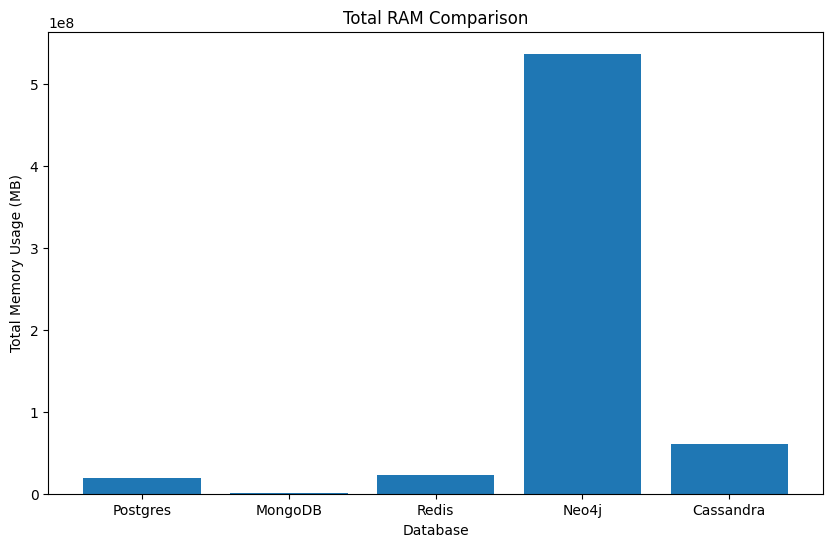

In [27]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Function to generate sample data (using generated data for test consistency)
def generate_data(total_rows):
    data = pd.DataFrame({
        'timestamp': range(total_rows),
        'visitorid': range(total_rows),
        'event': ['event'] * total_rows,
        'itemid': range(total_rows),
        'transactionid': range(total_rows)
    })
    return data


# Postgres: Insert data
def insert_postgres(data, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        cur.execute("INSERT INTO events (timestamp, visitorid, event, itemid, transactionid) VALUES (%s, %s, %s, %s, %s)",
                    (row['timestamp'], row['visitorid'], row['event'], row['itemid'], row['transactionid']))
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Insert data
def insert_mongodb(data, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    collection.insert_many(data.to_dict('records'))
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Insert data
def insert_redis(data):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        redis_client.hmset(f"event:{index}", row.to_dict())
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Insert data
def insert_neo4j(data, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        session.run("CREATE (e:Event {timestamp: $timestamp, visitorid: $visitorid, event: $event, itemid: $itemid, transactionid: $transactionid})", 
                    {'timestamp': str(row['timestamp']), 'visitorid': str(row['visitorid']), 'event': row['event'], 'itemid': str(row['itemid']), 'transactionid': str(row['transactionid'])})
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Insert data
def insert_cassandra(data, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for index, row in data.iterrows():
        session.execute(f"""
        INSERT INTO {keyspace}.{table} (timestamp, visitorid, event, itemid, transactionid) VALUES (%s, %s, %s, %s, %s)
        """, (row['timestamp'], row['visitorid'], row['event'], row['itemid'], row['transactionid']))
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'retailrocket',
    'table': 'events'
}



# Set the total number of rows to be inserted
total_rows = 1000000  # Example: set to 1,000,000 rows

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(1, len(str(total_rows))) if 10**i <= total_rows]
if total_rows not in record_factors:
    record_factors.append(total_rows)

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    # data = pd.read_csv('events.csv')
    data = generate_data(rows)
    
    time_taken, cpu_time, memory_usage = insert_postgres(data, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_mongodb(data, 'retailrocket', 'events')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_redis(data)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_neo4j(data, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_cassandra(data, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('insertion_results.csv')


#### 3.2.2. Batch Insertion in Retail Rocket Database

/tmp/ipykernel_2517/2932618174.py:112: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/2932618174.py:112: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/2932618174.py:112: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/2932618174.py:112: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/2932618174.py:112: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_dict())
/tmp/ipykernel_2517/2932618174.py:112: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", row.to_

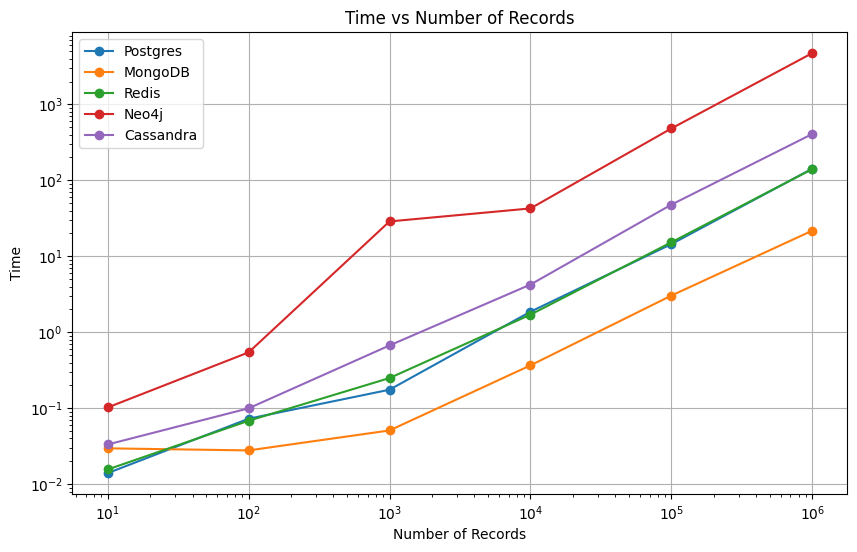

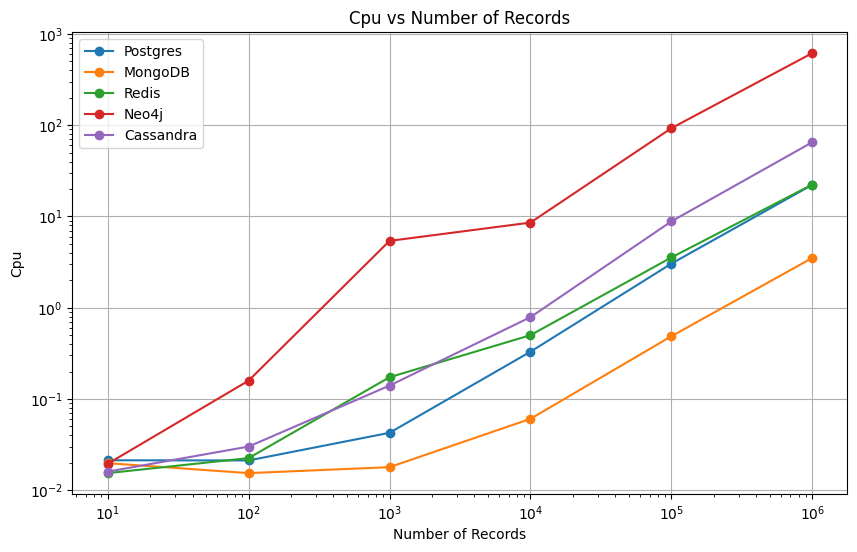

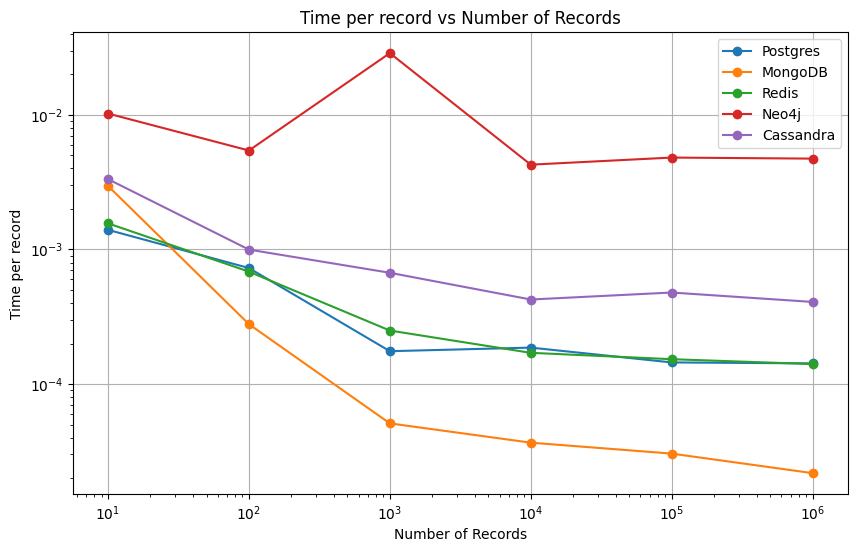

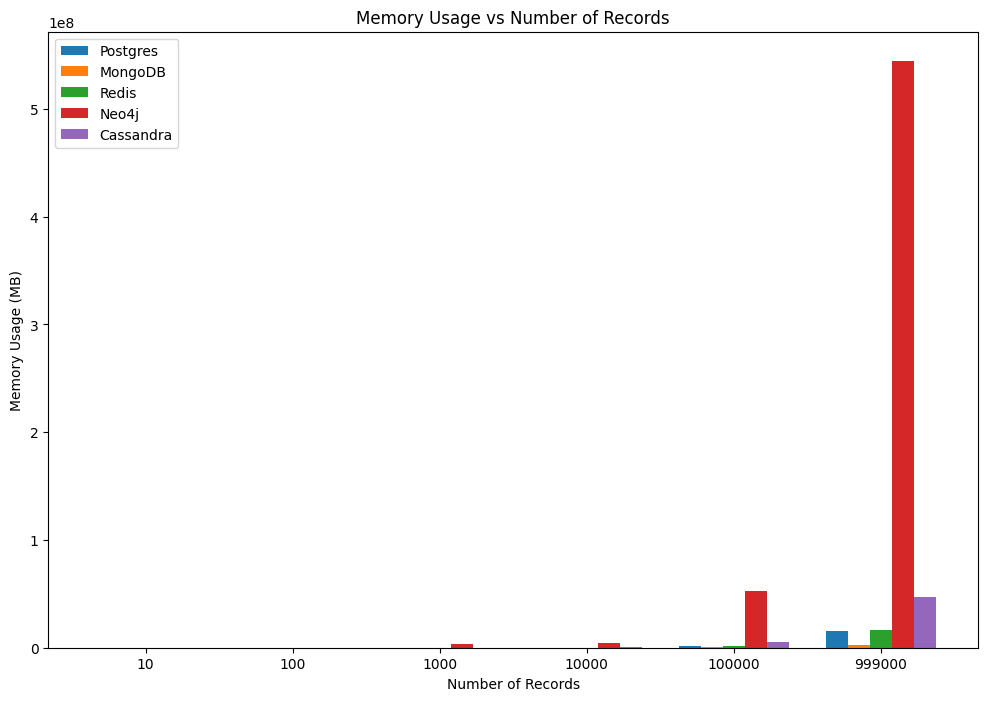

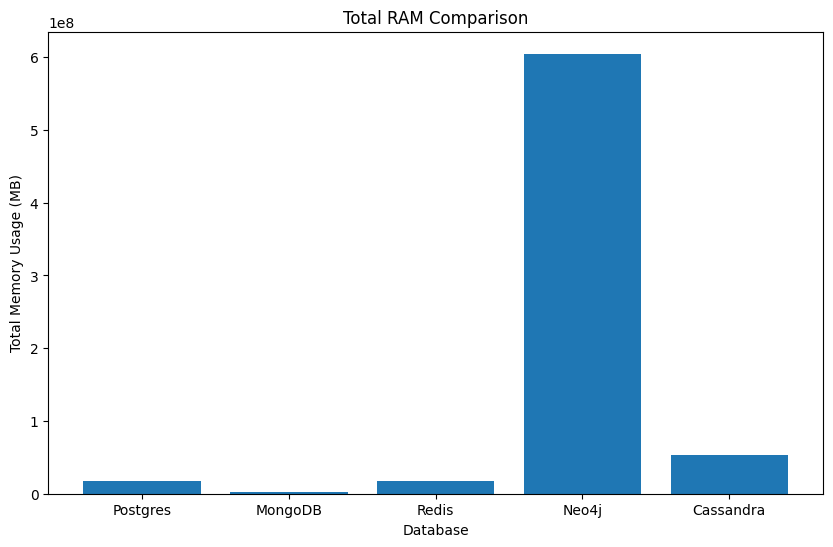

In [54]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Function to generate sample data
def generate_data(total_rows):
    data = pd.DataFrame({
        'timestamp': range(total_rows),
        'visitorid': range(total_rows),
        'event': ['event'] * total_rows,
        'itemid': range(total_rows),
        'transactionid': range(total_rows)
    })
    return data

# Function to insert data in batches
def insert_data_in_batches(insert_function, data, batch_size, *args):
    num_batches = (len(data) + batch_size - 1) // batch_size  # Ensure correct batch count
    total_time = 0
    total_cpu_time = 0
    total_memory_usage = 0
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    batch_results = []

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, len(data))
        if start_idx >= len(data):  # Ensure no extra rows are processed
            break
        batch_data = data.iloc[start_idx:end_idx]

        start_time = time.time()
        batch_time, batch_cpu_time, batch_memory_usage = insert_function(batch_data, *args)
        end_time = time.time()
        
        total_time += (end_time - start_time)
        total_cpu_time += batch_cpu_time
        total_memory_usage += batch_memory_usage
        
        batch_results.append((batch_time, batch_cpu_time, batch_memory_usage, batch_time / len(batch_data), len(batch_data)))
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time_batch, total_memory_usage_batch = resource_queue.get()
    
    return total_time, total_cpu_time_batch, total_memory_usage_batch, batch_results

# Postgres: Insert data
def insert_postgres_batch(data, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        cur.execute("INSERT INTO events (timestamp, visitorid, event, itemid, transactionid) VALUES (%s, %s, %s, %s, %s)",
                    (row['timestamp'], row['visitorid'], row['event'], row['itemid'], row['transactionid']))
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    return end_time - start_time, psutil.cpu_percent(interval=0), psutil.virtual_memory().used / (1024 * 1024)

# MongoDB: Insert data
def insert_mongodb_batch(data, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    start_time = time.time()
    
    collection.insert_many(data.to_dict('records'))
    
    end_time = time.time()
    client.close()
    
    return end_time - start_time, psutil.cpu_percent(interval=0), psutil.virtual_memory().used / (1024 * 1024)

# Redis: Insert data
def insert_redis_batch(data):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        redis_client.hmset(f"event:{index}", row.to_dict())
    
    end_time = time.time()
    redis_client.close()
    
    return end_time - start_time, psutil.cpu_percent(interval=0), psutil.virtual_memory().used / (1024 * 1024)

# Neo4j: Insert data
def insert_neo4j_batch(data, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        session.run("CREATE (e:Event {timestamp: $timestamp, visitorid: $visitorid, event: $event, itemid: $itemid, transactionid: $transactionid})", 
                    {'timestamp': str(row['timestamp']), 'visitorid': str(row['visitorid']), 'event': row['event'], 'itemid': str(row['itemid']), 'transactionid': str(row['transactionid'])})
    
    end_time = time.time()
    session.close()
    driver.close()
    
    return end_time - start_time, psutil.cpu_percent(interval=0), psutil.virtual_memory().used / (1024 * 1024)

# Cassandra: Insert data
def insert_cassandra_batch(data, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    start_time = time.time()
    
    for index, row in data.iterrows():
        session.execute(f"""
        INSERT INTO {keyspace}.{table} (timestamp, visitorid, event, itemid, transactionid) VALUES (%s, %s, %s, %s, %s)
        """, (row['timestamp'], row['visitorid'], row['event'], row['itemid'], row['transactionid']))
    
    end_time = time.time()
    cluster.shutdown()

    return end_time - start_time, psutil.cpu_percent(interval=0), psutil.virtual_memory().used / (1024 * 1024)

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'retailrocket',
    'table': 'events'
}

# Set the total number of rows to be inserted
# Using 999000 so that a total of 1000000 rows are inserted
total_rows = 999000  # Example: set to 1,000,000 rows

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(1, len(str(total_rows))) if 10**i <= total_rows]
if total_rows not in record_factors:
    record_factors.append(total_rows)

# Define batch size
batch_size = 1000  # Example batch size

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

batch_data_records = []

for rows in record_factors:
    # data = pd.read_csv('events.csv')
    data = generate_data(rows)
    
    time_taken, cpu_time, memory_usage, batch_results = insert_data_in_batches(insert_postgres_batch, data, batch_size, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    for batch_time, batch_cpu, batch_memory, batch_time_per_record, num_records in batch_results:
        batch_data_records.append({
            'database': 'Postgres',
            'batch_time': batch_time,
            'batch_cpu': batch_cpu,
            'batch_memory': batch_memory,
            'batch_time_per_record': batch_time_per_record,
            'number of records inserted': num_records
        })
    
    time_taken, cpu_time, memory_usage, batch_results = insert_data_in_batches(insert_mongodb_batch, data, batch_size, 'retailrocket', 'events')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    for batch_time, batch_cpu, batch_memory, batch_time_per_record, num_records in batch_results:
        batch_data_records.append({
            'database': 'MongoDB',
            'batch_time': batch_time,
            'batch_cpu': batch_cpu,
            'batch_memory': batch_memory,
            'batch_time_per_record': batch_time_per_record,
            'number of records inserted': num_records
        })
    
    time_taken, cpu_time, memory_usage, batch_results = insert_data_in_batches(insert_redis_batch, data, batch_size)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    for batch_time, batch_cpu, batch_memory, batch_time_per_record, num_records in batch_results:
        batch_data_records.append({
            'database': 'Redis',
            'batch_time': batch_time,
            'batch_cpu': batch_cpu,
            'batch_memory': batch_memory,
            'batch_time_per_record': batch_time_per_record,
            'number of records inserted': num_records
        })
    
    time_taken, cpu_time, memory_usage, batch_results = insert_data_in_batches(insert_neo4j_batch, data, batch_size, neo4j_params['uri'], neo4j_params['user'], neo4j_params['password'])
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    for batch_time, batch_cpu, batch_memory, batch_time_per_record, num_records in batch_results:
        batch_data_records.append({
            'database': 'Neo4j',
            'batch_time': batch_time,
            'batch_cpu': batch_cpu,
            'batch_memory': batch_memory,
            'batch_time_per_record': batch_time_per_record,
            'number of records inserted': num_records
        })
    
    time_taken, cpu_time, memory_usage, batch_results = insert_data_in_batches(insert_cassandra_batch, data, batch_size, cassandra_params['keyspace'], cassandra_params['table'])
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)
    for batch_time, batch_cpu, batch_memory, batch_time_per_record, num_records in batch_results:
        batch_data_records.append({
            'database': 'Cassandra',
            'batch_time': batch_time,
            'batch_cpu': batch_cpu,
            'batch_memory': batch_memory,
            'batch_time_per_record': batch_time_per_record,
            'number of records inserted': num_records
        })

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('insertion_results_batches.csv')

# Save batch results to CSV
df_batch_results = pd.DataFrame(batch_data_records)
df_batch_results.to_csv('insertion_results_batches_detailed.csv', index=False)



### 3.3.  Reading Retail Rocket Database

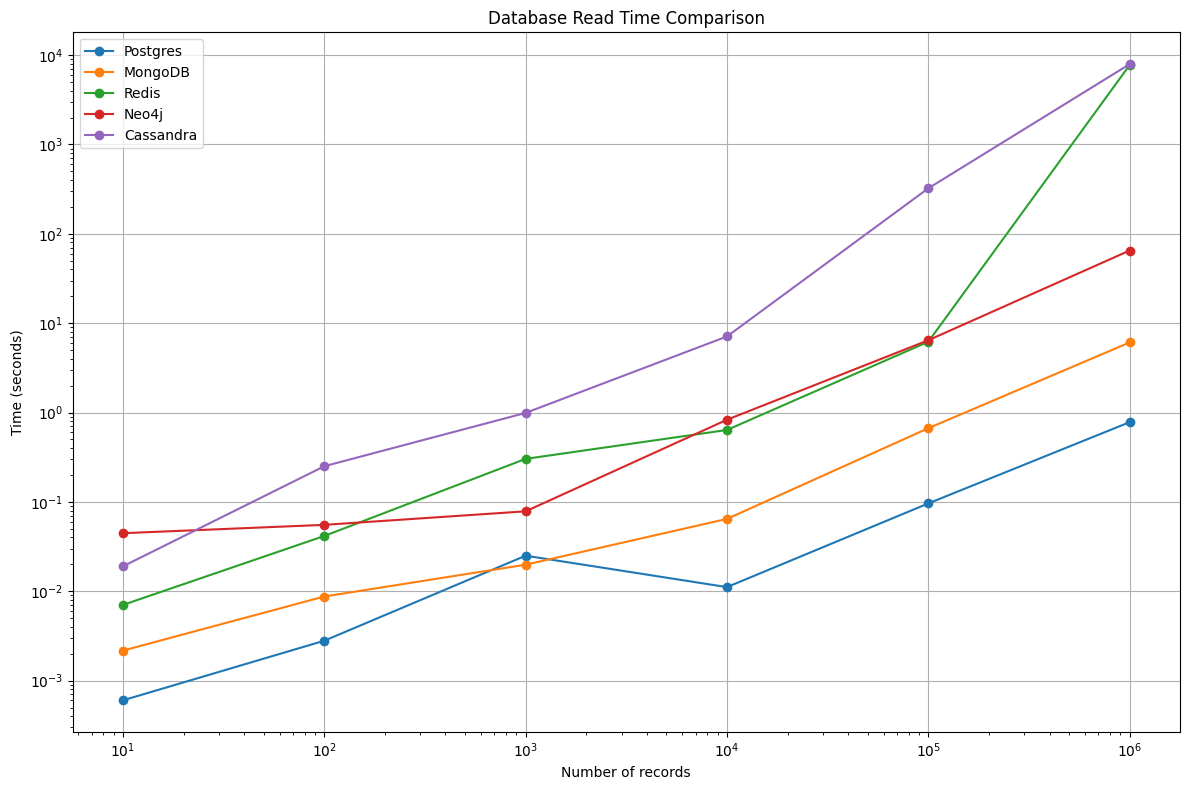

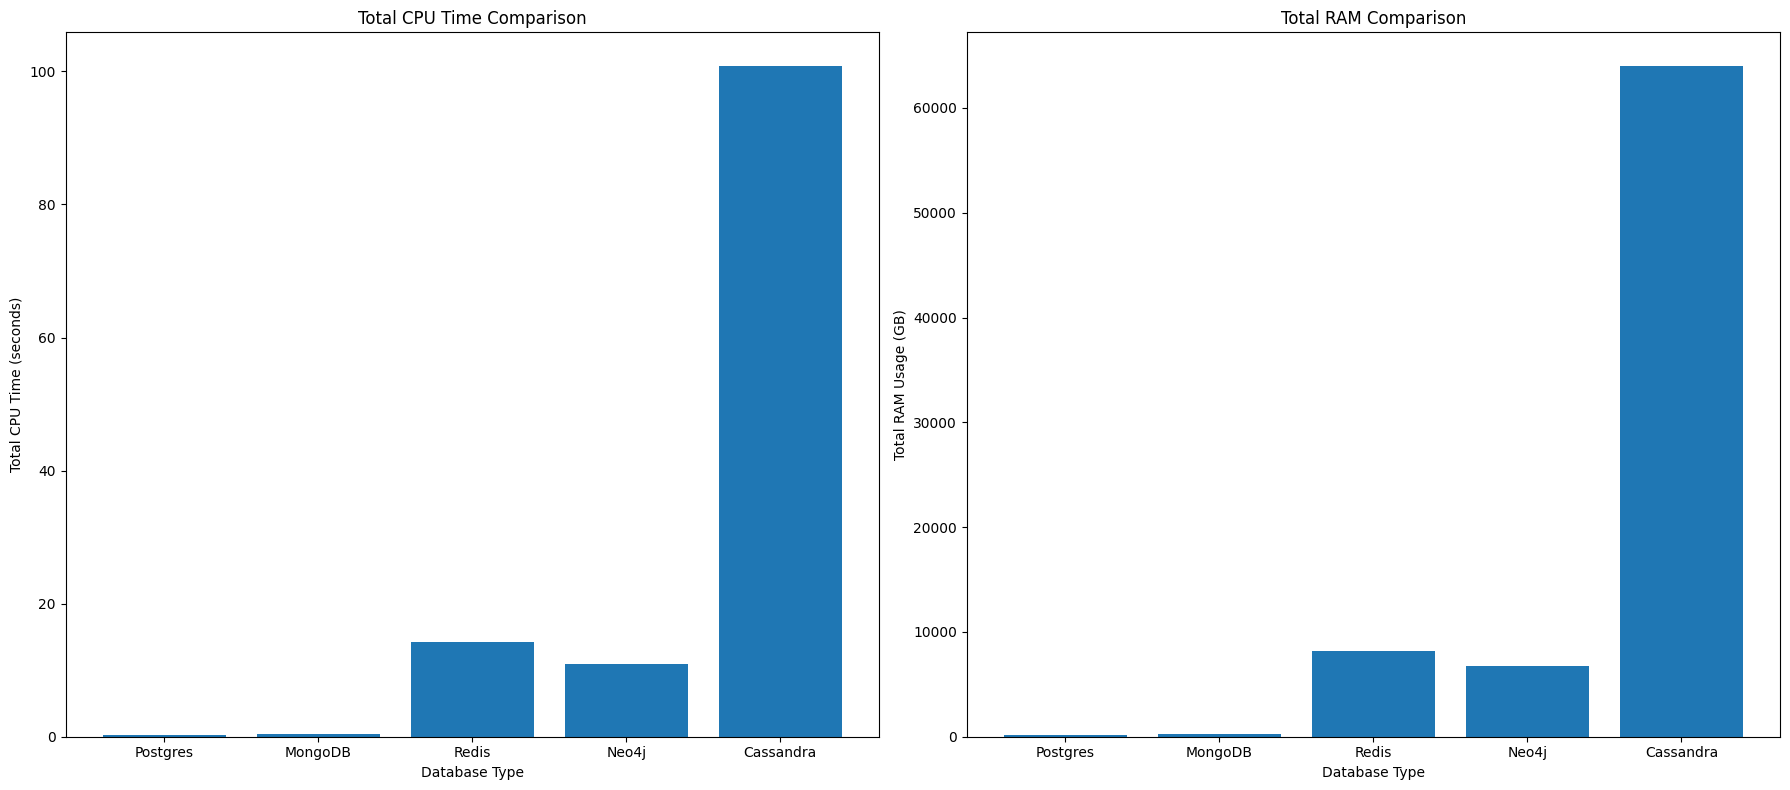

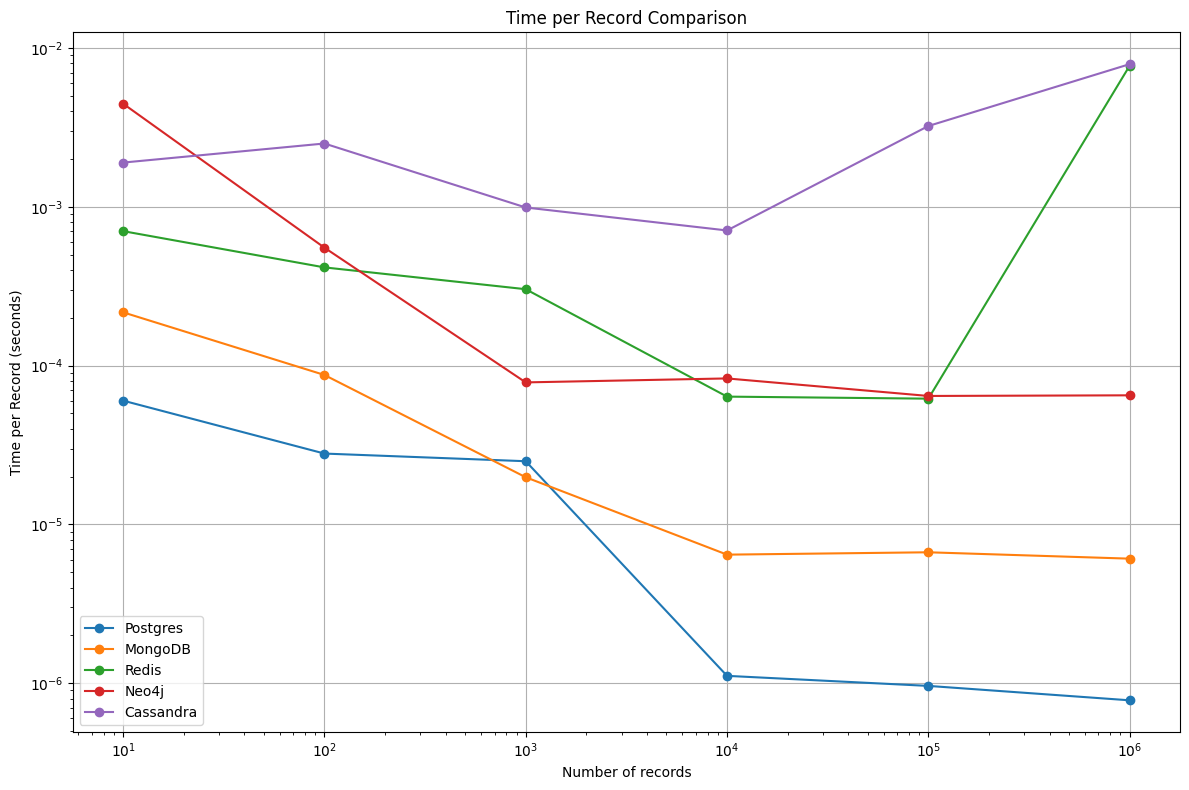

In [7]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Postgres: Read records
def read_postgres(rows, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()

    cur.execute("SELECT * FROM events LIMIT %s;", (rows,))
    rows_data = cur.fetchall()

    end_time = time.time()
    conn.close()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Read records
def read_mongodb(rows, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()

    documents = list(collection.find().limit(rows))

    end_time = time.time()
    client.close()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Read records
def read_redis(rows):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()

    data = []
    for i in range(rows):
        data.append(redis_client.hgetall(f"event:{i}"))

    end_time = time.time()
    redis_client.close()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Read records
def read_neo4j(rows, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()

    result = session.run("MATCH (e:Event) RETURN e LIMIT $rows", {'rows': rows})
    data = [record['e'] for record in result]

    end_time = time.time()
    session.close()
    driver.close()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Read records
def read_cassandra(rows, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()

    data = []
    for i in range(rows):
        row = session.execute(f"SELECT * FROM {keyspace}.{table} WHERE timestamp = %s", (i,)).one()
        if row:
            data.append(row)

    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'retailrocket',
    'table': 'events'
}

# Manually set the total number of rows to read
total_rows = 1000000  # Example: set to 1,000,000 rows

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(1, len(str(total_rows))) if 10**i <= total_rows]
if total_rows not in record_factors:
    record_factors.append(total_rows)

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    time_taken, cpu_time, memory_usage = read_postgres(rows, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = read_mongodb(rows, 'retailrocket', 'events')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = read_redis(rows)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = read_neo4j(rows, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = read_cassandra(rows, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Aggregating total CPU time and memory usage for each database type
total_cpu_time = {
    'Postgres': sum(results['Postgres']['cpu']),
    'MongoDB': sum(results['MongoDB']['cpu']),
    'Redis': sum(results['Redis']['cpu']),
    'Neo4j': sum(results['Neo4j']['cpu']),
    'Cassandra': sum(results['Cassandra']['cpu'])
}

total_memory_usage = {
    'Postgres': sum(results['Postgres']['memory']) / 1024,  # Convert MB to GB
    'MongoDB': sum(results['MongoDB']['memory']) / 1024,   # Convert MB to GB
    'Redis': sum(results['Redis']['memory']) / 1024,       # Convert MB to GB
    'Neo4j': sum(results['Neo4j']['memory']) / 1024,       # Convert MB to GB
    'Cassandra': sum(results['Cassandra']['memory']) / 1024 # Convert MB to GB
}

# Save results to CSV
df_results = pd.DataFrame({
    'Records': record_factors,
    'Postgres Time (s)': results['Postgres']['time'],
    'MongoDB Time (s)': results['MongoDB']['time'],
    'Redis Time (s)': results['Redis']['time'],
    'Neo4j Time (s)': results['Neo4j']['time'],
    'Cassandra Time (s)': results['Cassandra']['time'],
    'Postgres CPU Time (s)': results['Postgres']['cpu'],
    'MongoDB CPU Time (s)': results['MongoDB']['cpu'],
    'Redis CPU Time (s)': results['Redis']['cpu'],
    'Neo4j CPU Time (s)': results['Neo4j']['cpu'],
    'Cassandra CPU Time (s)': results['Cassandra']['cpu'],
    'Postgres Memory (GB)': results['Postgres']['memory'],
    'MongoDB Memory (GB)': results['MongoDB']['memory'],
    'Redis Memory (GB)': results['Redis']['memory'],
    'Neo4j Memory (GB)': results['Neo4j']['memory'],
    'Cassandra Memory (GB)': results['Cassandra']['memory'],
    'Postgres Time per Record (s)': results['Postgres']['time_per_record'],
    'MongoDB Time per Record (s)': results['MongoDB']['time_per_record'],
    'Redis Time per Record (s)': results['Redis']['time_per_record'],
    'Neo4j Time per Record (s)': results['Neo4j']['time_per_record'],
    'Cassandra Time per Record (s)': results['Cassandra']['time_per_record']
})
df_results.to_csv('database_read_results.csv', index=False)

# Plotting Database Read Time Comparison
fig1, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(record_factors, results['Postgres']['time'], label='Postgres', marker='o')
ax1.plot(record_factors, results['MongoDB']['time'], label='MongoDB', marker='o')
ax1.plot(record_factors, results['Redis']['time'], label='Redis', marker='o')
ax1.plot(record_factors, results['Neo4j']['time'], label='Neo4j', marker='o')
ax1.plot(record_factors, results['Cassandra']['time'], label='Cassandra', marker='o')
ax1.set_xlabel('Number of records')
ax1.set_ylabel('Time (seconds)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Database Read Time Comparison')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.savefig('database_read_time_comparison.png')
plt.show()

# Plotting Total CPU Time Comparison and Total RAM Comparison side by side
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting total CPU time
ax2.bar(total_cpu_time.keys(), total_cpu_time.values())
ax2.set_xlabel('Database Type')
ax2.set_ylabel('Total CPU Time (seconds)')
ax2.set_title('Total CPU Time Comparison')
ax2.grid(False)

# Plotting total memory usage
ax3.bar(total_memory_usage.keys(), total_memory_usage.values())
ax3.set_xlabel('Database Type')
ax3.set_ylabel('Total RAM Usage (GB)')
ax3.set_title('Total RAM Comparison')
ax3.grid(False)

plt.tight_layout()
plt.savefig('cpu_ram_comparison_read.png')
plt.show()

# Plotting Time per Record Comparison
fig3, ax4 = plt.subplots(figsize=(12, 8))

ax4.plot(record_factors, results['Postgres']['time_per_record'], label='Postgres', marker='o')
ax4.plot(record_factors, results['MongoDB']['time_per_record'], label='MongoDB', marker='o')
ax4.plot(record_factors, results['Redis']['time_per_record'], label='Redis', marker='o')
ax4.plot(record_factors, results['Neo4j']['time_per_record'], label='Neo4j', marker='o')
ax4.plot(record_factors, results['Cassandra']['time_per_record'], label='Cassandra', marker='o')
ax4.set_xlabel('Number of records')
ax4.set_ylabel('Time per Record (seconds)')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title('Time per Record Comparison')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.savefig('time_per_record_comparison_read.png')
plt.show()


### 3.4. Updating Retail Rocket Database

For Consistency in update operation 'visitorid', 'event', 'itemid' and 'transactionid' features are updated in all the 5 databases namely Postgres, Mongodb, Cassandra, Redis and Neo4j. Since, 'timestamp' feature is the primary key in cassandra so it is left same.

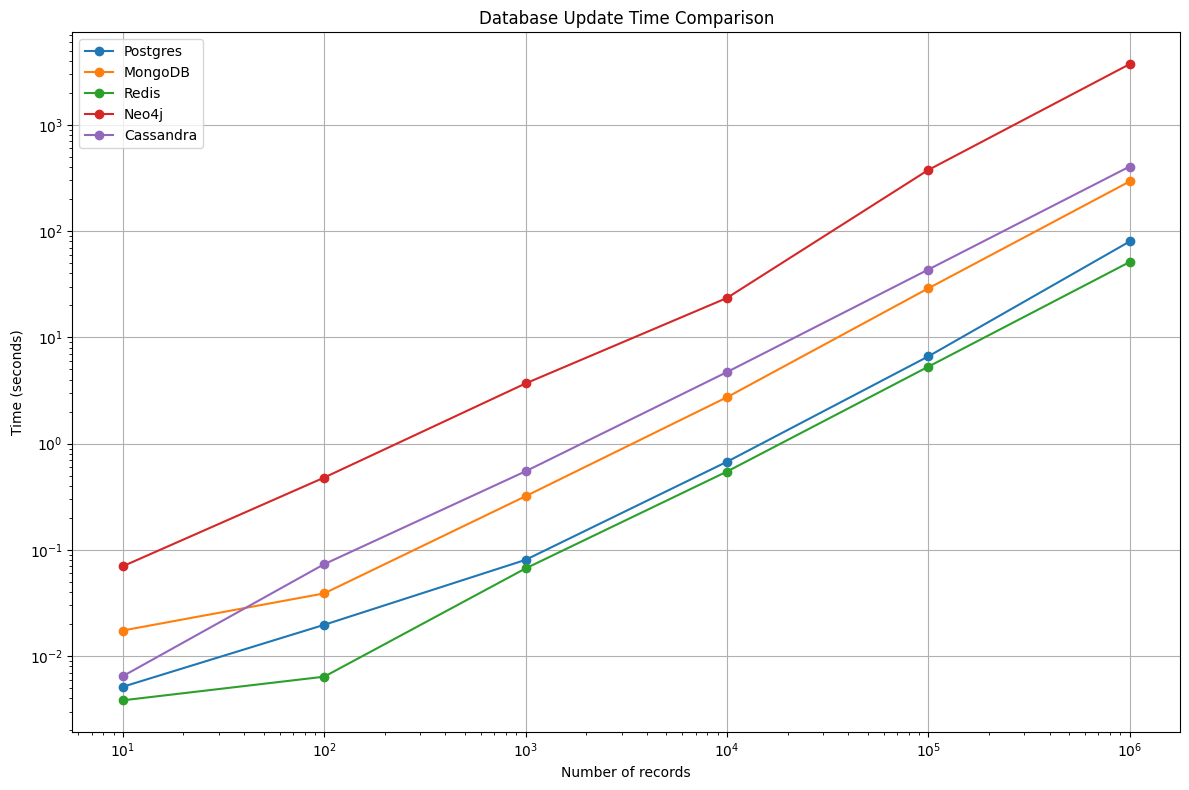

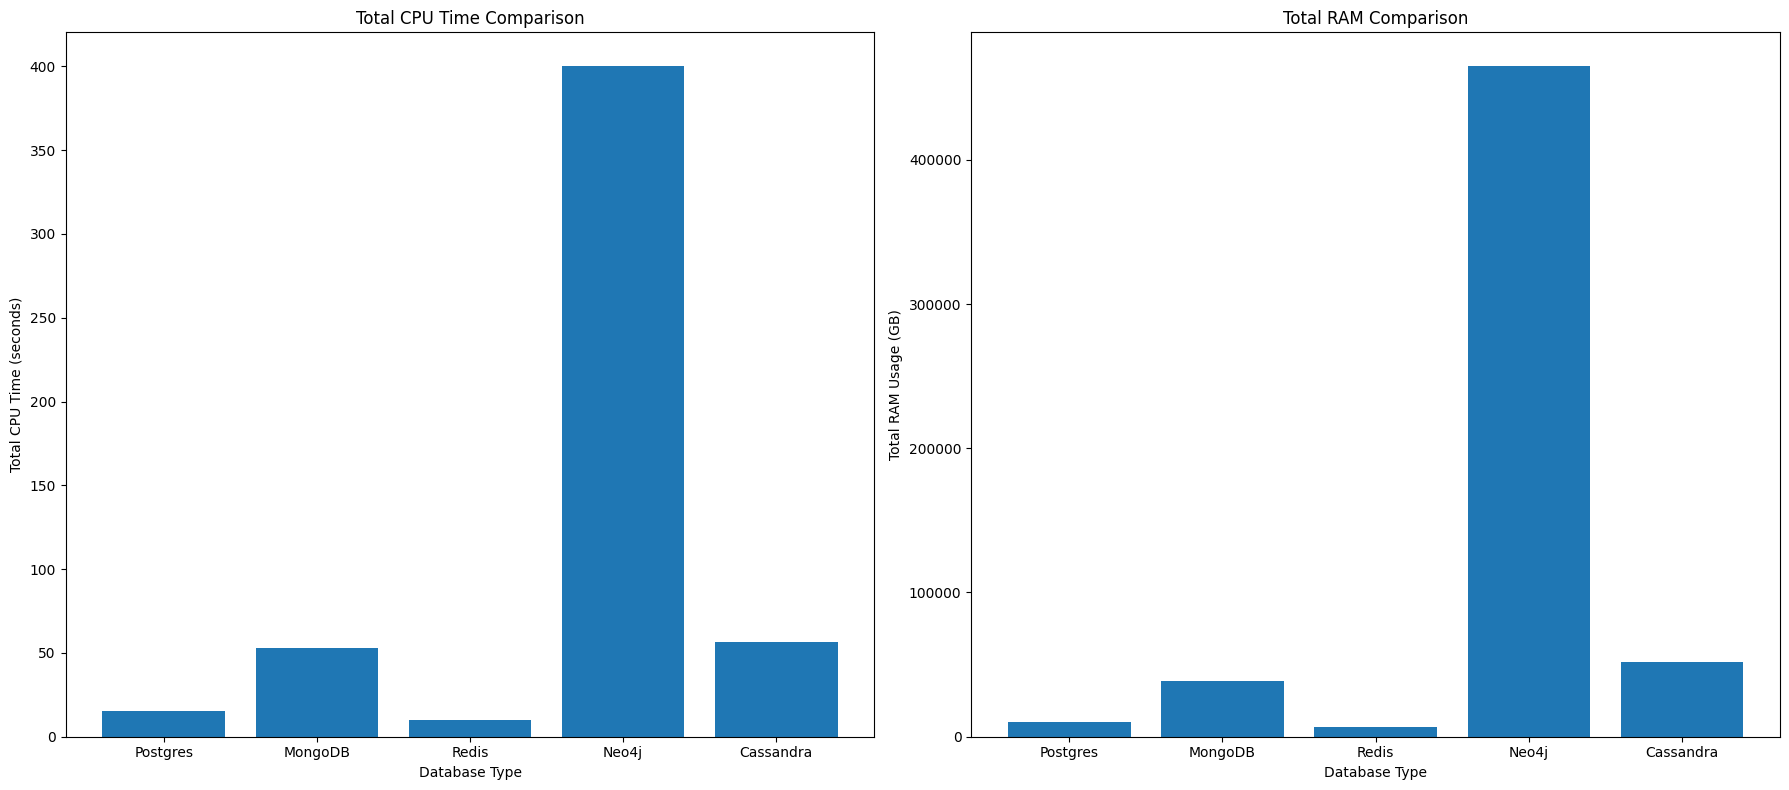

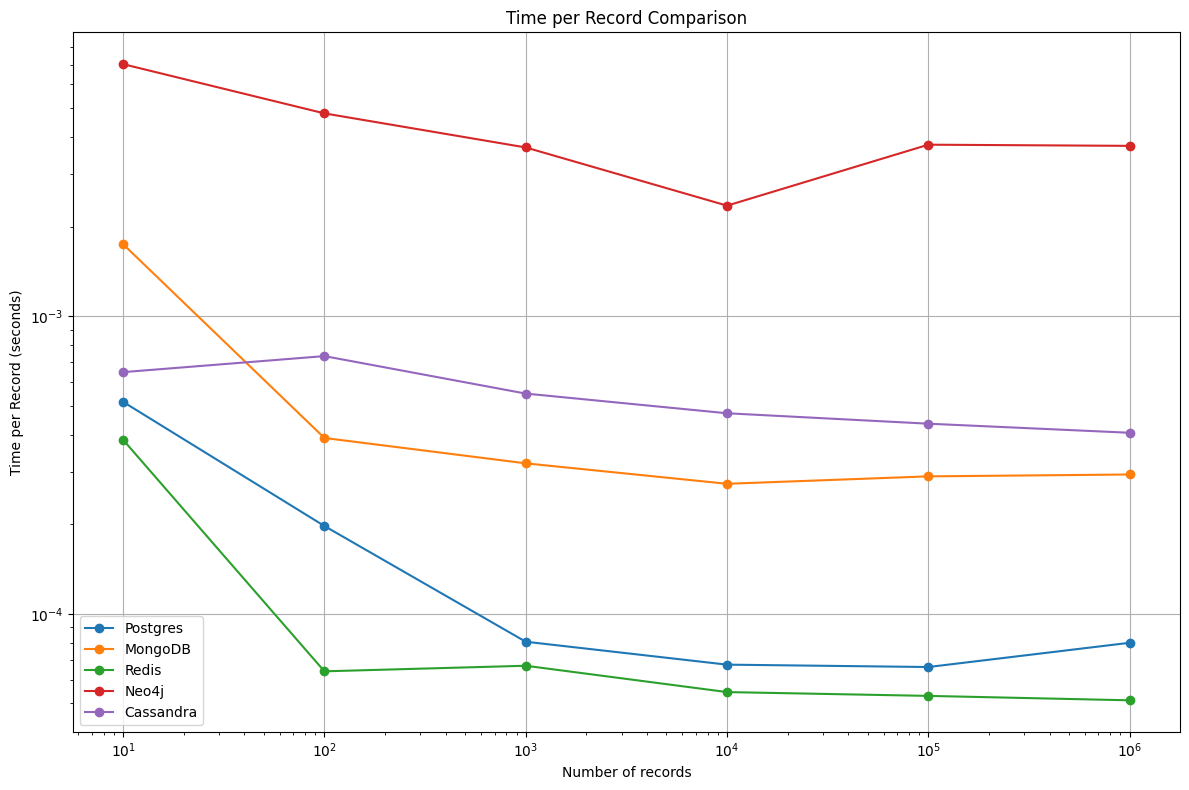

In [8]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Postgres: Update records
def update_postgres(rows, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute("SELECT ctid, * FROM events LIMIT %s;", (rows,))
    rows_data = cur.fetchall()
    
    for row in rows_data:
        ctid = row[0]
        cur.execute("""
        UPDATE events 
        SET visitorid = visitorid + 1, event = 'updated', itemid = itemid + 1, transactionid = transactionid + 1
        WHERE ctid = %s;
        """, (ctid,))
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Update records
def update_mongodb(rows, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    documents = list(collection.find().limit(rows))
    for document in documents:
        collection.update_one({'_id': document['_id']}, {'$inc': {'visitorid': 1, 'itemid': 1, 'transactionid': 1}, '$set': {'event': 'updated'}})
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Update records
def update_redis(rows):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for i in range(rows):
        redis_client.hset(f"event:{i}", mapping={'visitorid': i + 1, 'event': 'updated', 'itemid': i + 1, 'transactionid': i + 1})
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Update records
def update_neo4j(rows, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    result = session.run("MATCH (e:Event) RETURN id(e) AS id LIMIT $rows", {'rows': rows})
    ids = [record['id'] for record in result]
    
    for node_id in ids:
        session.run("""
        MATCH (e:Event) WHERE id(e) = $id
        SET e.visitorid = toInteger(e.visitorid) + 1, e.event = 'updated', e.itemid = toInteger(e.itemid) + 1, e.transactionid = toInteger(e.transactionid) + 1
        """, {'id': node_id})
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Update records without batch processing
def update_cassandra(rows, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for i in range(rows):
        row = session.execute(f"SELECT * FROM {keyspace}.{table} WHERE timestamp = %s", (i,)).one()
        if row:
            new_visitorid = row.visitorid + 1
            new_itemid = row.itemid + 1
            new_transactionid = row.transactionid + 1
            session.execute(f"""
            UPDATE {keyspace}.{table}
            SET visitorid = %s, event = %s, itemid = %s, transactionid = %s
            WHERE timestamp = %s
            """, (new_visitorid, 'updated', new_itemid, new_transactionid, i))

    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'retailrocket',
    'table': 'events'
}

# Get the total number of rows in each database (excluding Cassandra)
def get_total_rows():
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM events;")
    total_rows_postgres = cur.fetchone()[0]
    conn.close()
    
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client['retailrocket']
    collection = db['events']
    total_rows_mongodb = collection.count_documents({})
    client.close()
    
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    total_rows_redis = len(redis_client.keys('event:*'))
    redis_client.close()
    
    driver = GraphDatabase.driver(neo4j_params['uri'], auth=(neo4j_params['user'], neo4j_params['password']))
    session = driver.session()
    result = session.run("MATCH (e:Event) RETURN count(e) AS total_rows")
    total_rows_neo4j = result.single()['total_rows']
    session.close()
    driver.close()
    
    return min(total_rows_postgres, total_rows_mongodb, total_rows_redis, total_rows_neo4j)

# Manually set the total number of rows to be updated for Cassandra and other databases
total_rows_cassandra = 1000000  # Example: set to 1,000,000 rows

# Set total_rows for all the databases manually
total_rows = min(get_total_rows(), total_rows_cassandra)

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(1, len(str(total_rows))) if 10**i <= total_rows]
if total_rows not in record_factors:
    record_factors.append(total_rows)

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    time_taken, cpu_time, memory_usage = update_postgres(rows, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = update_mongodb(rows, 'retailrocket', 'events')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = update_redis(rows)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = update_neo4j(rows, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = update_cassandra(rows, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Aggregating total CPU time and memory usage for each database type
total_cpu_time = {
    'Postgres': sum(results['Postgres']['cpu']),
    'MongoDB': sum(results['MongoDB']['cpu']),
    'Redis': sum(results['Redis']['cpu']),
    'Neo4j': sum(results['Neo4j']['cpu']),
    'Cassandra': sum(results['Cassandra']['cpu'])
}

total_memory_usage = {
    'Postgres': sum(results['Postgres']['memory']) / 1024,  # Convert MB to GB
    'MongoDB': sum(results['MongoDB']['memory']) / 1024,   # Convert MB to GB
    'Redis': sum(results['Redis']['memory']) / 1024,       # Convert MB to GB
    'Neo4j': sum(results['Neo4j']['memory']) / 1024,       # Convert MB to GB
    'Cassandra': sum(results['Cassandra']['memory']) / 1024 # Convert MB to GB
}

# Save results to CSV
df_results = pd.DataFrame({
    'Records': record_factors,
    'Postgres Time (s)': results['Postgres']['time'],
    'MongoDB Time (s)': results['MongoDB']['time'],
    'Redis Time (s)': results['Redis']['time'],
    'Neo4j Time (s)': results['Neo4j']['time'],
    'Cassandra Time (s)': results['Cassandra']['time'],
    'Postgres CPU Time (s)': results['Postgres']['cpu'],
    'MongoDB CPU Time (s)': results['MongoDB']['cpu'],
    'Redis CPU Time (s)': results['Redis']['cpu'],
    'Neo4j CPU Time (s)': results['Neo4j']['cpu'],
    'Cassandra CPU Time (s)': results['Cassandra']['cpu'],
    'Postgres Memory (GB)': results['Postgres']['memory'],
    'MongoDB Memory (GB)': results['MongoDB']['memory'],
    'Redis Memory (GB)': results['Redis']['memory'],
    'Neo4j Memory (GB)': results['Neo4j']['memory'],
    'Cassandra Memory (GB)': results['Cassandra']['memory'],
    'Postgres Time per Record (s)': results['Postgres']['time_per_record'],
    'MongoDB Time per Record (s)': results['MongoDB']['time_per_record'],
    'Redis Time per Record (s)': results['Redis']['time_per_record'],
    'Neo4j Time per Record (s)': results['Neo4j']['time_per_record'],
    'Cassandra Time per Record (s)': results['Cassandra']['time_per_record']
})
df_results.to_csv('database_update_results.csv', index=False)

# Plotting Database Update Time Comparison
fig1, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(record_factors, results['Postgres']['time'], label='Postgres', marker='o')
ax1.plot(record_factors, results['MongoDB']['time'], label='MongoDB', marker='o')
ax1.plot(record_factors, results['Redis']['time'], label='Redis', marker='o')
ax1.plot(record_factors, results['Neo4j']['time'], label='Neo4j', marker='o')
ax1.plot(record_factors, results['Cassandra']['time'], label='Cassandra', marker='o')
ax1.set_xlabel('Number of records')
ax1.set_ylabel('Time (seconds)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Database Update Time Comparison')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.savefig('database_update_time_comparison.png')
plt.show()

# Plotting Total CPU Time Comparison and Total RAM Comparison side by side
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting total CPU time
ax2.bar(total_cpu_time.keys(), total_cpu_time.values())
ax2.set_xlabel('Database Type')
ax2.set_ylabel('Total CPU Time (seconds)')
ax2.set_title('Total CPU Time Comparison')
ax2.grid(False)

# Plotting total memory usage
ax3.bar(total_memory_usage.keys(), total_memory_usage.values())
ax3.set_xlabel('Database Type')
ax3.set_ylabel('Total RAM Usage (GB)')
ax3.set_title('Total RAM Comparison')
ax3.grid(False)

plt.tight_layout()
plt.savefig('cpu_ram_comparison_update.png')
plt.show()

# Plotting Time per Record Comparison
fig3, ax4 = plt.subplots(figsize=(12, 8))

ax4.plot(record_factors, results['Postgres']['time_per_record'], label='Postgres', marker='o')
ax4.plot(record_factors, results['MongoDB']['time_per_record'], label='MongoDB', marker='o')
ax4.plot(record_factors, results['Redis']['time_per_record'], label='Redis', marker='o')
ax4.plot(record_factors, results['Neo4j']['time_per_record'], label='Neo4j', marker='o')
ax4.plot(record_factors, results['Cassandra']['time_per_record'], label='Cassandra', marker='o')
ax4.set_xlabel('Number of records')
ax4.set_ylabel('Time per Record (seconds)')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title('Time per Record Comparison')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.savefig('time_per_record_comparison.png')
plt.show()



### 3.5. Deleting Retail Rocket Database

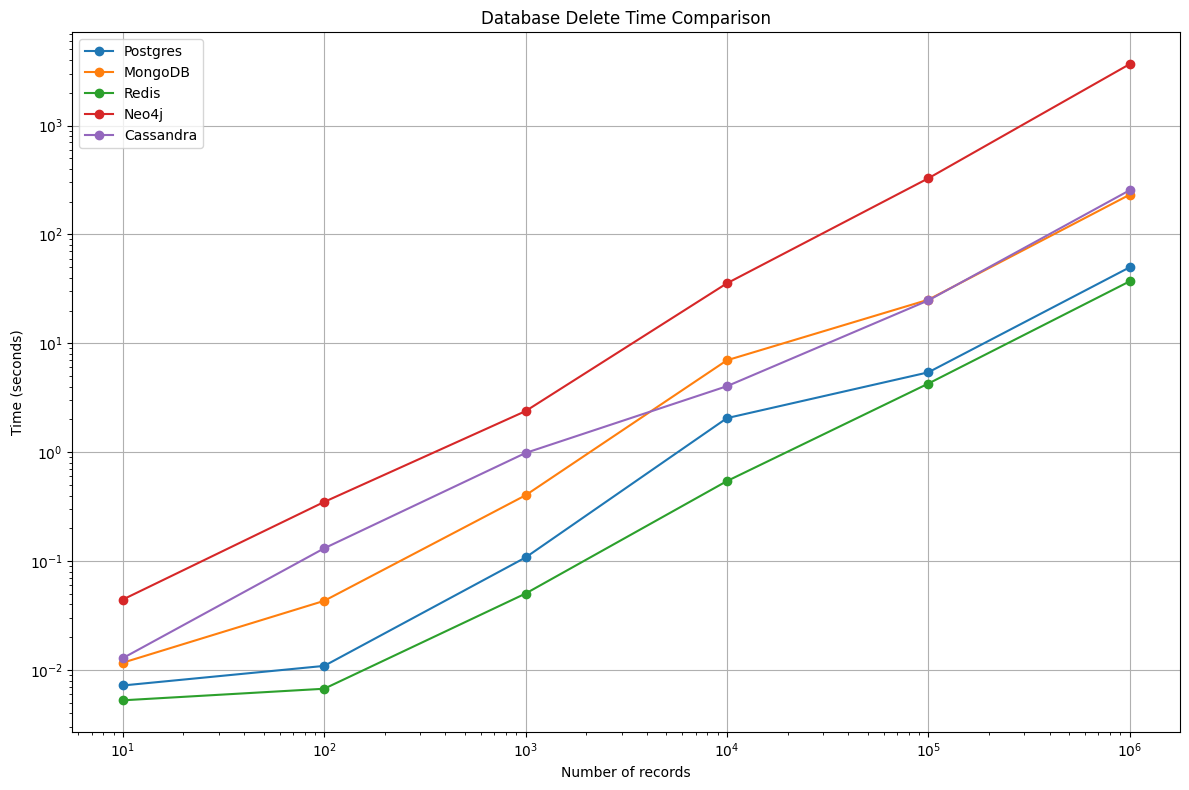

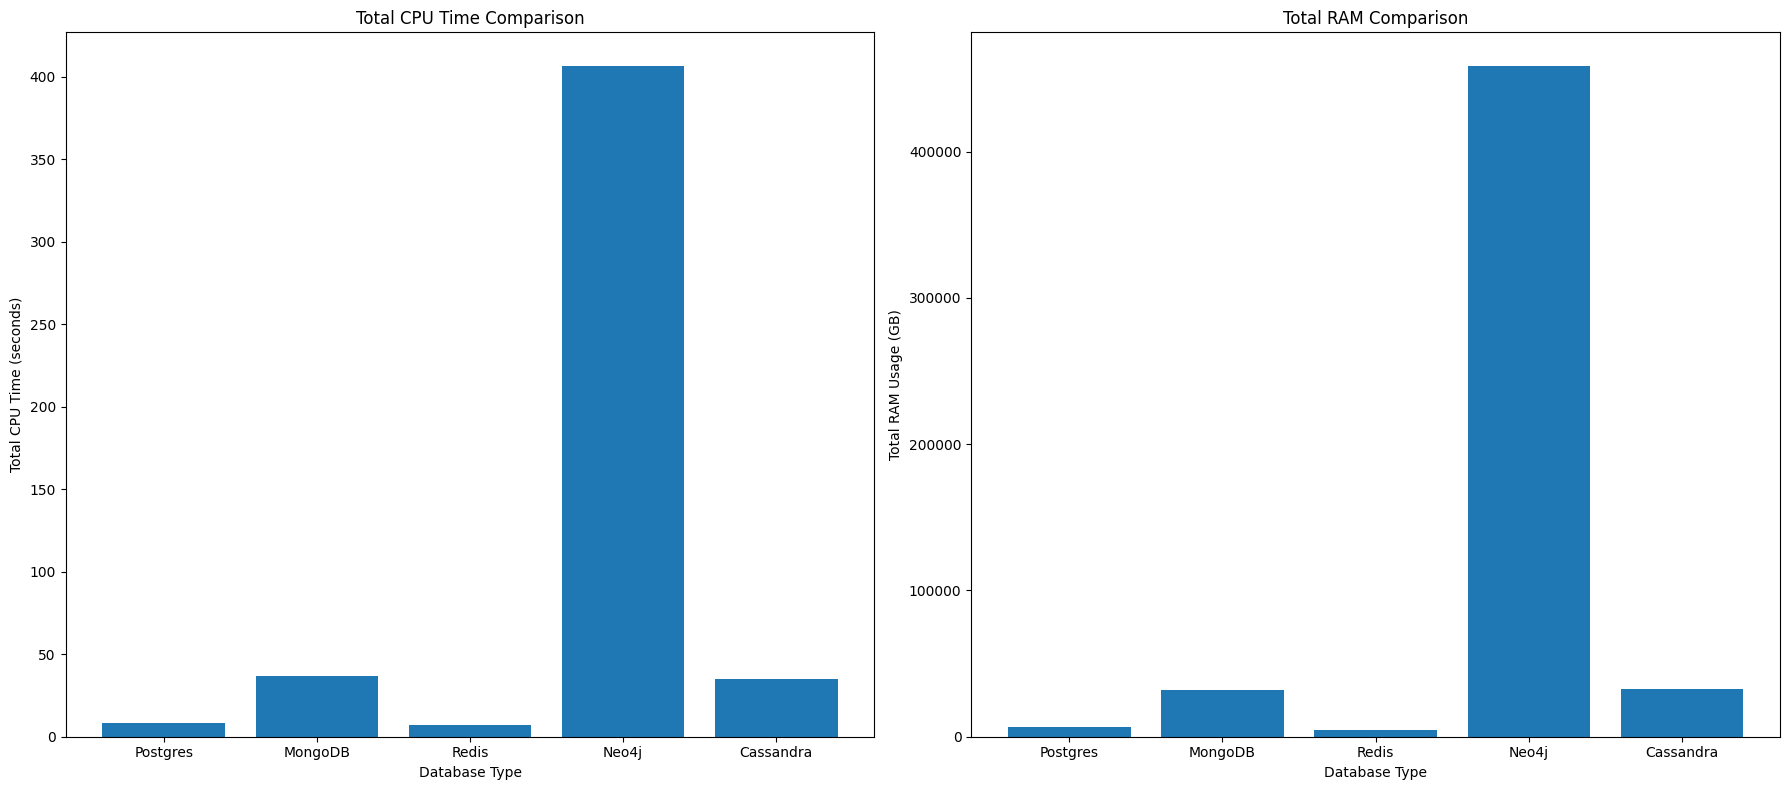

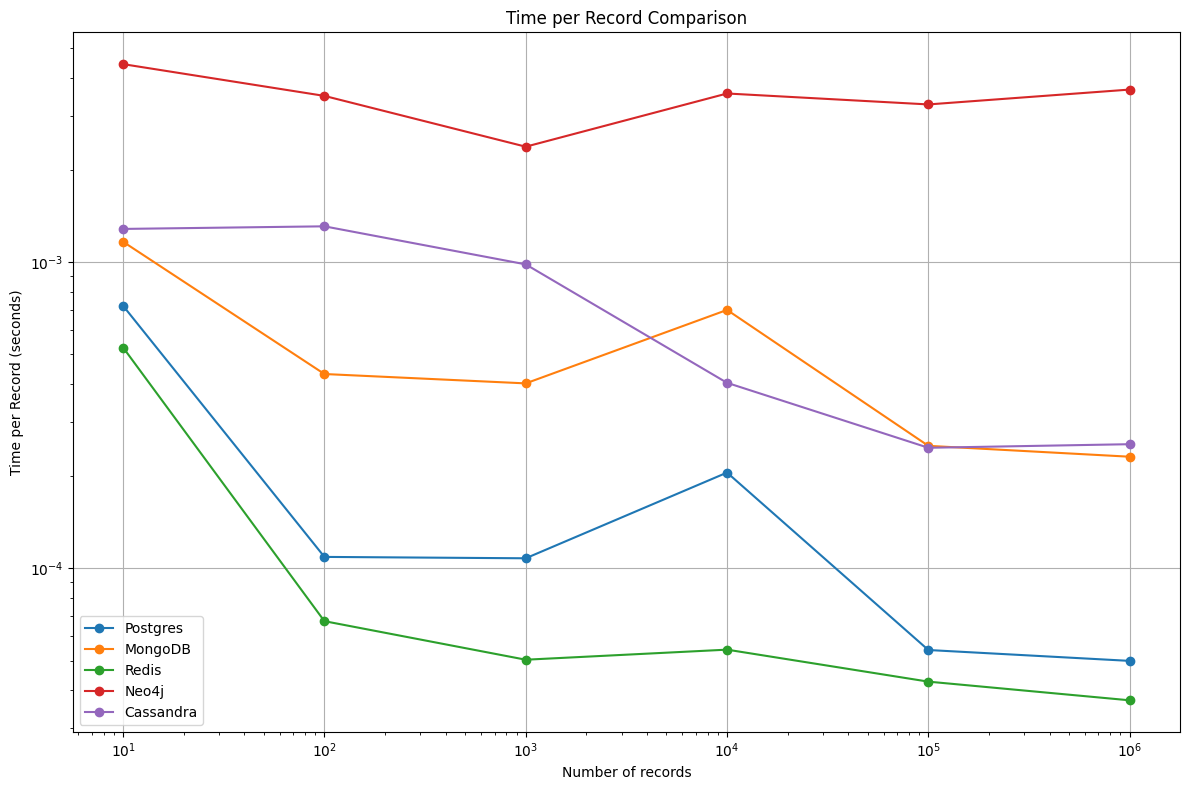

In [9]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Postgres: Delete records
def delete_postgres(rows, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute("SELECT ctid FROM events LIMIT %s;", (rows,))
    rows_data = cur.fetchall()
    
    for row in rows_data:
        ctid = row[0]
        cur.execute("DELETE FROM events WHERE ctid = %s;", (ctid,))
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Delete records
def delete_mongodb(rows, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    documents = list(collection.find().limit(rows))
    for document in documents:
        collection.delete_one({'_id': document['_id']})
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Delete records
def delete_redis(rows):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for i in range(rows):
        redis_client.delete(f"event:{i}")
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Delete records
def delete_neo4j(rows, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    result = session.run("MATCH (e:Event) RETURN id(e) AS id LIMIT $rows", {'rows': rows})
    ids = [record['id'] for record in result]
    
    for node_id in ids:
        session.run("MATCH (e:Event) WHERE id(e) = $id DETACH DELETE e", {'id': node_id})
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Delete records without batch processing
def delete_cassandra(rows, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for i in range(rows):
        session.execute(f"DELETE FROM {keyspace}.{table} WHERE timestamp = %s", (i,))

    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'retailrocket',
    'table': 'events'
}

# Get the total number of rows in each database (excluding Cassandra)
def get_total_rows():
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM events;")
    total_rows_postgres = cur.fetchone()[0]
    conn.close()
    
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client['retailrocket']
    collection = db['events']
    total_rows_mongodb = collection.count_documents({})
    client.close()
    
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    total_rows_redis = len(redis_client.keys('event:*'))
    redis_client.close()
    
    driver = GraphDatabase.driver(neo4j_params['uri'], auth=(neo4j_params['user'], neo4j_params['password']))
    session = driver.session()
    result = session.run("MATCH (e:Event) RETURN count(e) AS total_rows")
    total_rows_neo4j = result.single()['total_rows']
    session.close()
    driver.close()
    
    return min(total_rows_postgres, total_rows_mongodb, total_rows_redis, total_rows_neo4j)

# Set total_rows manually
total_rows = 1000000 # Example: set to 1,000,000 rows

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(1, len(str(total_rows))) if 10**i <= total_rows]
if total_rows not in record_factors:
    record_factors.append(total_rows)

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    time_taken, cpu_time, memory_usage = delete_postgres(rows, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = delete_mongodb(rows, 'retailrocket', 'events')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = delete_redis(rows)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = delete_neo4j(rows, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = delete_cassandra(rows, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Aggregating total CPU time and memory usage for each database type
total_cpu_time = {
    'Postgres': sum(results['Postgres']['cpu']),
    'MongoDB': sum(results['MongoDB']['cpu']),
    'Redis': sum(results['Redis']['cpu']),
    'Neo4j': sum(results['Neo4j']['cpu']),
    'Cassandra': sum(results['Cassandra']['cpu'])
}

total_memory_usage = {
    'Postgres': sum(results['Postgres']['memory']) / 1024,  # Convert MB to GB
    'MongoDB': sum(results['MongoDB']['memory']) / 1024,   # Convert MB to GB
    'Redis': sum(results['Redis']['memory']) / 1024,       # Convert MB to GB
    'Neo4j': sum(results['Neo4j']['memory']) / 1024,       # Convert MB to GB
    'Cassandra': sum(results['Cassandra']['memory']) / 1024 # Convert MB to GB
}

# Save results to CSV
df_results = pd.DataFrame({
    'Records': record_factors,
    'Postgres Time (s)': results['Postgres']['time'],
    'MongoDB Time (s)': results['MongoDB']['time'],
    'Redis Time (s)': results['Redis']['time'],
    'Neo4j Time (s)': results['Neo4j']['time'],
    'Cassandra Time (s)': results['Cassandra']['time'],
    'Postgres CPU Time (s)': results['Postgres']['cpu'],
    'MongoDB CPU Time (s)': results['MongoDB']['cpu'],
    'Redis CPU Time (s)': results['Redis']['cpu'],
    'Neo4j CPU Time (s)': results['Neo4j']['cpu'],
    'Cassandra CPU Time (s)': results['Cassandra']['cpu'],
    'Postgres Memory (GB)': results['Postgres']['memory'],
    'MongoDB Memory (GB)': results['MongoDB']['memory'],
    'Redis Memory (GB)': results['Redis']['memory'],
    'Neo4j Memory (GB)': results['Neo4j']['memory'],
    'Cassandra Memory (GB)': results['Cassandra']['memory'],
    'Postgres Time per Record (s)': results['Postgres']['time_per_record'],
    'MongoDB Time per Record (s)': results['MongoDB']['time_per_record'],
    'Redis Time per Record (s)': results['Redis']['time_per_record'],
    'Neo4j Time per Record (s)': results['Neo4j']['time_per_record'],
    'Cassandra Time per Record (s)': results['Cassandra']['time_per_record']
})
df_results.to_csv('database_delete_results.csv', index=False)

# Plotting Database Delete Time Comparison
fig1, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(record_factors, results['Postgres']['time'], label='Postgres', marker='o')
ax1.plot(record_factors, results['MongoDB']['time'], label='MongoDB', marker='o')
ax1.plot(record_factors, results['Redis']['time'], label='Redis', marker='o')
ax1.plot(record_factors, results['Neo4j']['time'], label='Neo4j', marker='o')
ax1.plot(record_factors, results['Cassandra']['time'], label='Cassandra', marker='o')
ax1.set_xlabel('Number of records')
ax1.set_ylabel('Time (seconds)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Database Delete Time Comparison')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.savefig('database_delete_time_comparison.png')
plt.show()

# Plotting Total CPU Time Comparison and Total RAM Comparison side by side
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting total CPU time
ax2.bar(total_cpu_time.keys(), total_cpu_time.values())
ax2.set_xlabel('Database Type')
ax2.set_ylabel('Total CPU Time (seconds)')
ax2.set_title('Total CPU Time Comparison')
ax2.grid(False)

# Plotting total memory usage
ax3.bar(total_memory_usage.keys(), total_memory_usage.values())
ax3.set_xlabel('Database Type')
ax3.set_ylabel('Total RAM Usage (GB)')
ax3.set_title('Total RAM Comparison')
ax3.grid(False)

plt.tight_layout()
plt.savefig('cpu_ram_comparison_delete.png')
plt.show()

# Plotting Time per Record Comparison
fig3, ax4 = plt.subplots(figsize=(12, 8))

ax4.plot(record_factors, results['Postgres']['time_per_record'], label='Postgres', marker='o')
ax4.plot(record_factors, results['MongoDB']['time_per_record'], label='MongoDB', marker='o')
ax4.plot(record_factors, results['Redis']['time_per_record'], label='Redis', marker='o')
ax4.plot(record_factors, results['Neo4j']['time_per_record'], label='Neo4j', marker='o')
ax4.plot(record_factors, results['Cassandra']['time_per_record'], label='Cassandra', marker='o')
ax4.set_xlabel('Number of records')
ax4.set_ylabel('Time per Record (seconds)')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title('Time per Record Comparison')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.savefig('time_per_record_comparison_delete.png')
plt.show()



## 4. Diginetica Dataset

### 4.1 Create Diginetica Database

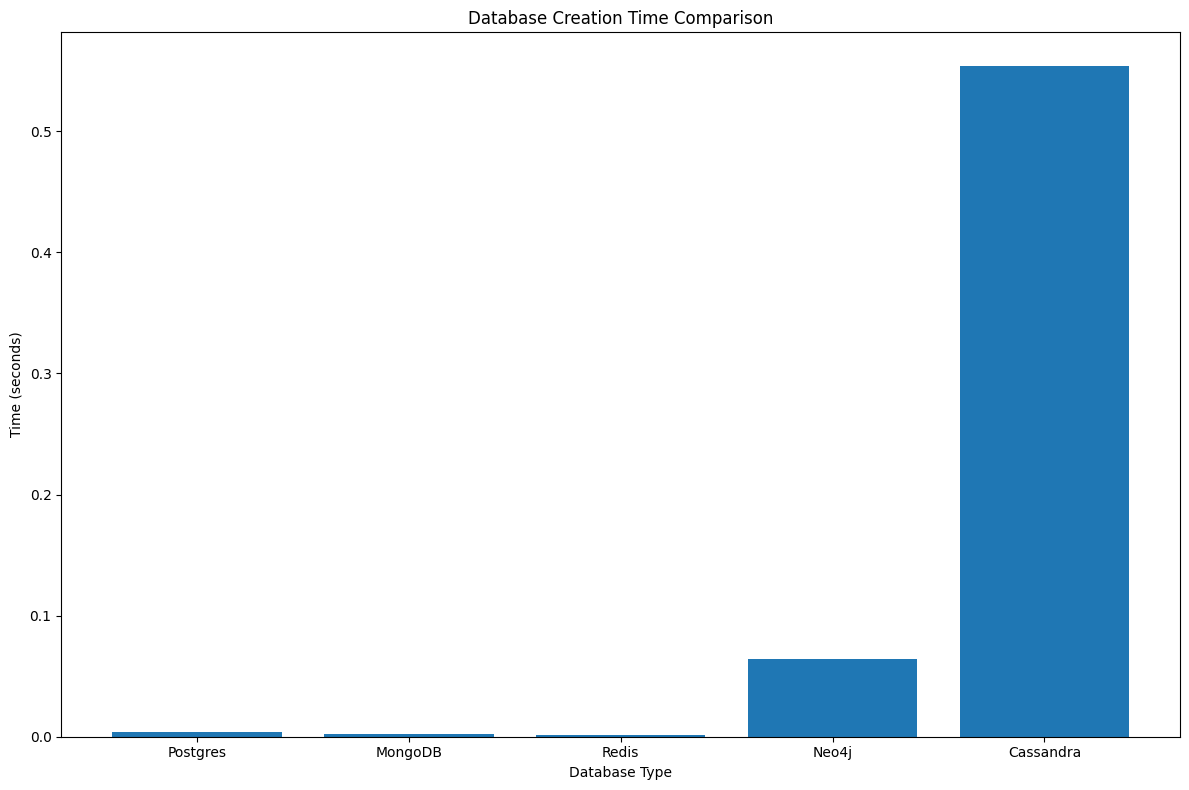

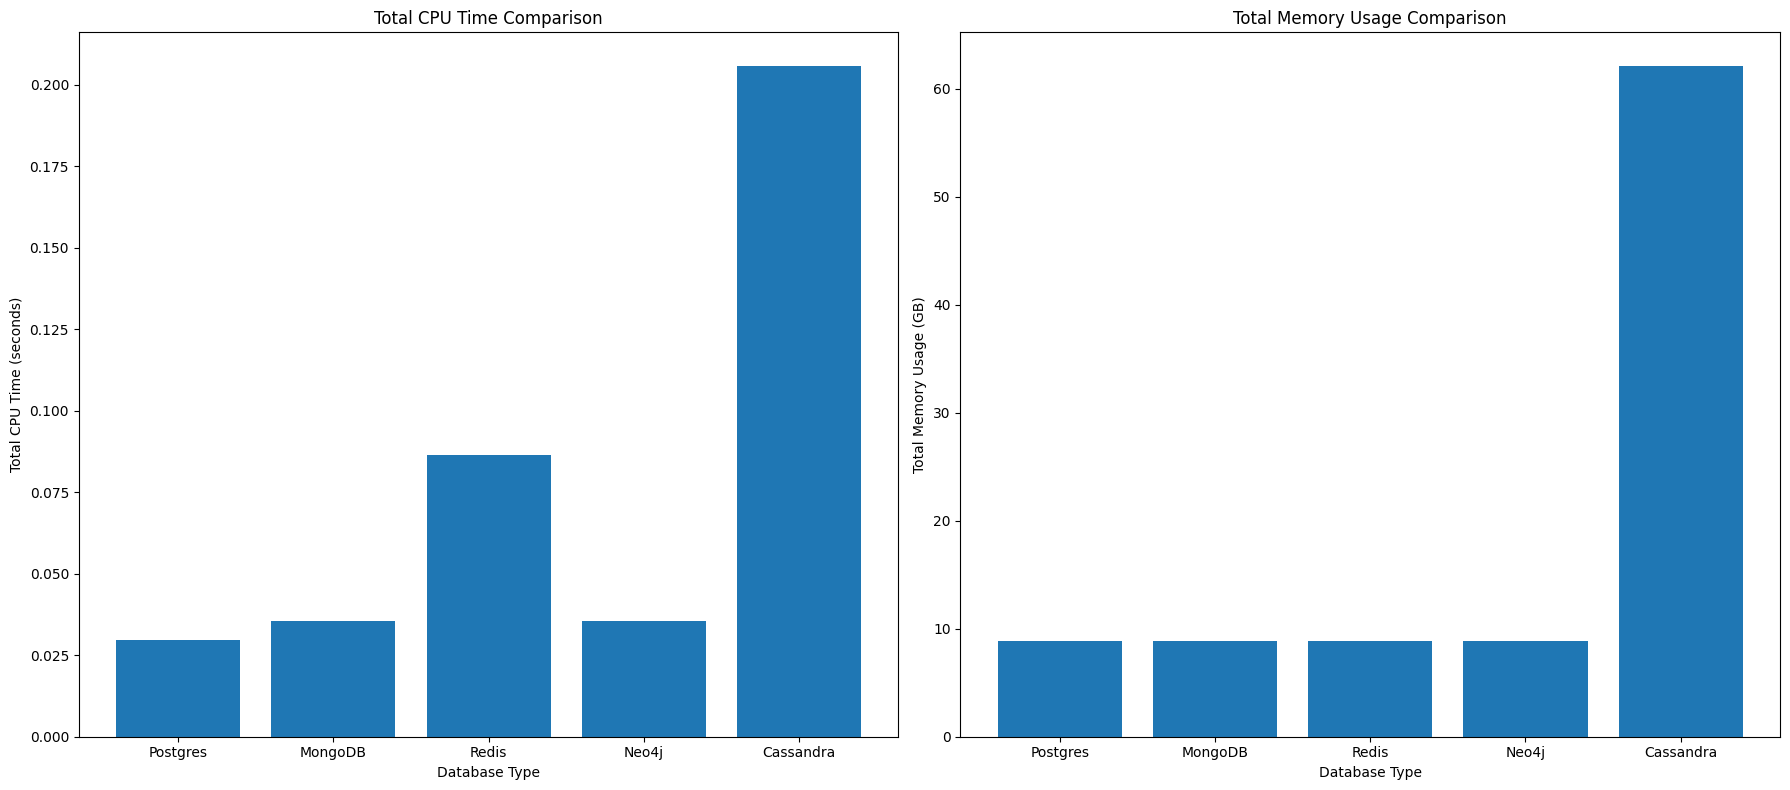

In [9]:
# Load the CSV file to determine the structure
df = pd.read_csv('train-clicks.csv')
columns = df.columns

# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Postgres: Create database
def create_postgres(db_params, columns):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute("DROP TABLE IF EXISTS train_clicks;")
    cur.execute(f"""
    CREATE TABLE train_clicks (
        {', '.join([f'{col} TEXT' for col in columns])}
    );
    """)
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Create database
def create_mongodb(db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    collection.drop()
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Create database
def create_redis():
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    redis_client.flushdb()
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Create database
def create_neo4j(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    session.run("MATCH (n) DETACH DELETE n")
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Create database
def create_cassandra(keyspace, table, columns):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    session.execute(f"DROP KEYSPACE IF EXISTS {keyspace}")
    session.execute(f"CREATE KEYSPACE {keyspace} WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}}")
    session.execute(f"""
    CREATE TABLE {keyspace}.{table} (
        {', '.join([f'{col} text PRIMARY KEY' if i == 0 else f'{col} text' for i, col in enumerate(columns)])}
    );
    """)
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'diginetica',
    'table': 'train_clicks'
}

results = {'Postgres': {'time': [], 'cpu': [], 'memory': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': []},
           'Redis': {'time': [], 'cpu': [], 'memory': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': []}}

# Create databases and measure time, CPU, and memory usage
time_taken, cpu_time, memory_usage = create_postgres(db_params, columns)
results['Postgres']['time'].append(time_taken)
results['Postgres']['cpu'].append(cpu_time)
results['Postgres']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_mongodb('diginetica', 'train_clicks')
results['MongoDB']['time'].append(time_taken)
results['MongoDB']['cpu'].append(cpu_time)
results['MongoDB']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_redis()
results['Redis']['time'].append(time_taken)
results['Redis']['cpu'].append(cpu_time)
results['Redis']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_neo4j(**neo4j_params)
results['Neo4j']['time'].append(time_taken)
results['Neo4j']['cpu'].append(cpu_time)
results['Neo4j']['memory'].append(memory_usage)

time_taken, cpu_time, memory_usage = create_cassandra(**cassandra_params, columns=columns)
results['Cassandra']['time'].append(time_taken)
results['Cassandra']['cpu'].append(cpu_time)
results['Cassandra']['memory'].append(memory_usage)

# Save results to CSV
df_results = pd.DataFrame({
    'Database': ['Postgres', 'MongoDB', 'Redis', 'Neo4j', 'Cassandra'],
    'Time (s)': [results['Postgres']['time'][0], results['MongoDB']['time'][0], results['Redis']['time'][0], results['Neo4j']['time'][0], results['Cassandra']['time'][0]],
    'CPU Time (s)': [results['Postgres']['cpu'][0], results['MongoDB']['cpu'][0], results['Redis']['cpu'][0], results['Neo4j']['cpu'][0], results['Cassandra']['cpu'][0]],
    'Memory Usage (GB)': [results['Postgres']['memory'][0] / 1024, results['MongoDB']['memory'][0] / 1024, results['Redis']['memory'][0] / 1024, results['Neo4j']['memory'][0] / 1024, results['Cassandra']['memory'][0] / 1024]
})
df_results.to_csv('diginetica_database_creation_results.csv', index=False)

# Plotting Database Creation Time Comparison
fig1, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(df_results['Database'], df_results['Time (s)'])
ax1.set_xlabel('Database Type')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Database Creation Time Comparison')
ax1.grid(False)

plt.tight_layout()
plt.savefig('diginetica_database_creation_time_comparison.png')
plt.show()

# Plotting Total CPU Time and Memory Usage side by side
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting total CPU time
ax2.bar(df_results['Database'], df_results['CPU Time (s)'])
ax2.set_xlabel('Database Type')
ax2.set_ylabel('Total CPU Time (seconds)')
ax2.set_title('Total CPU Time Comparison')
ax2.grid(False)

# Plotting total memory usage
ax3.bar(df_results['Database'], df_results['Memory Usage (GB)'])
ax3.set_xlabel('Database Type')
ax3.set_ylabel('Total Memory Usage (GB)')
ax3.set_title('Total Memory Usage Comparison')
ax3.grid(False)

plt.tight_layout()
plt.savefig('diginetica_cpu_ram_comparison_creation.png')
plt.show()



### 4.2. Inserting Records into Diginetica Database

#### 4.2.1. Bulk Insertion in Diginetica Database

/tmp/ipykernel_26296/1155681359.py:91: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1155681359.py:91: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1155681359.py:91: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1155681359.py:91: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1155681359.py:91: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})


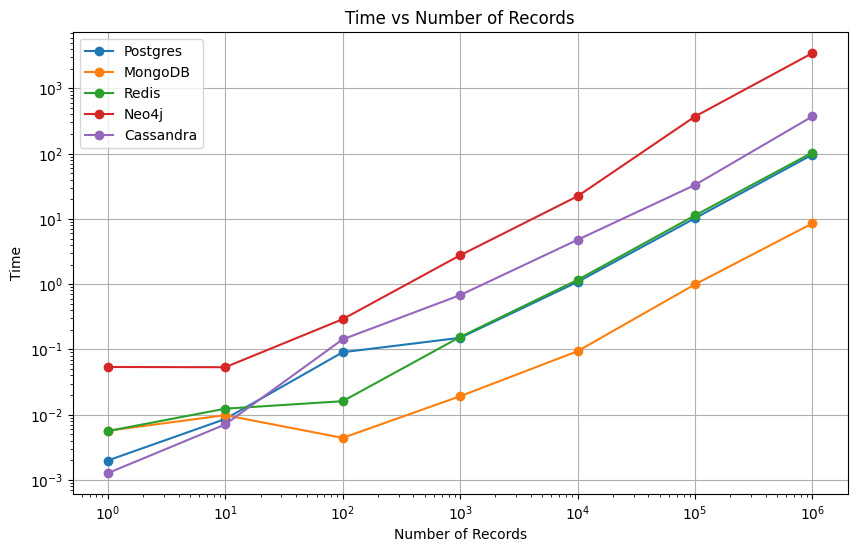

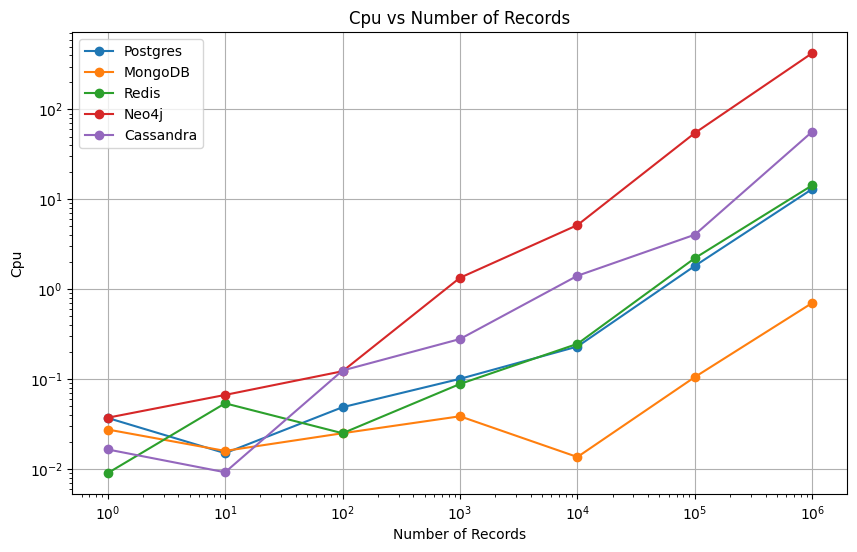

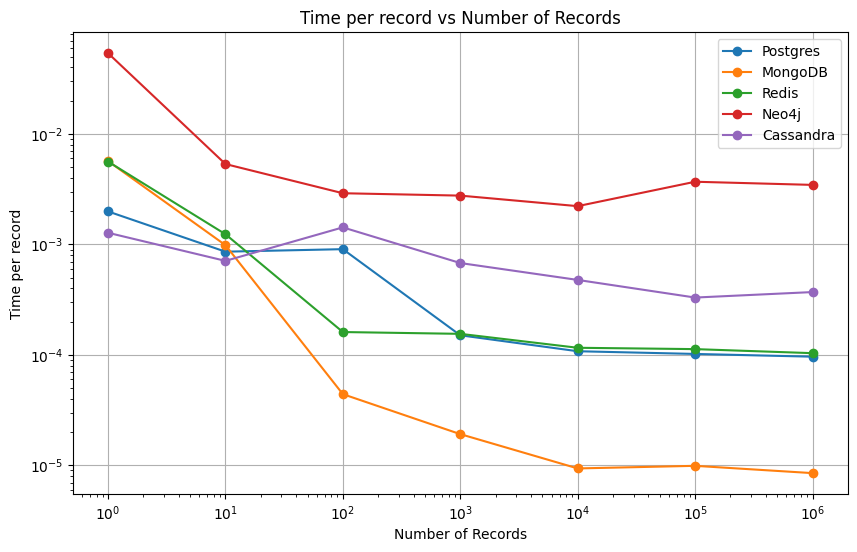

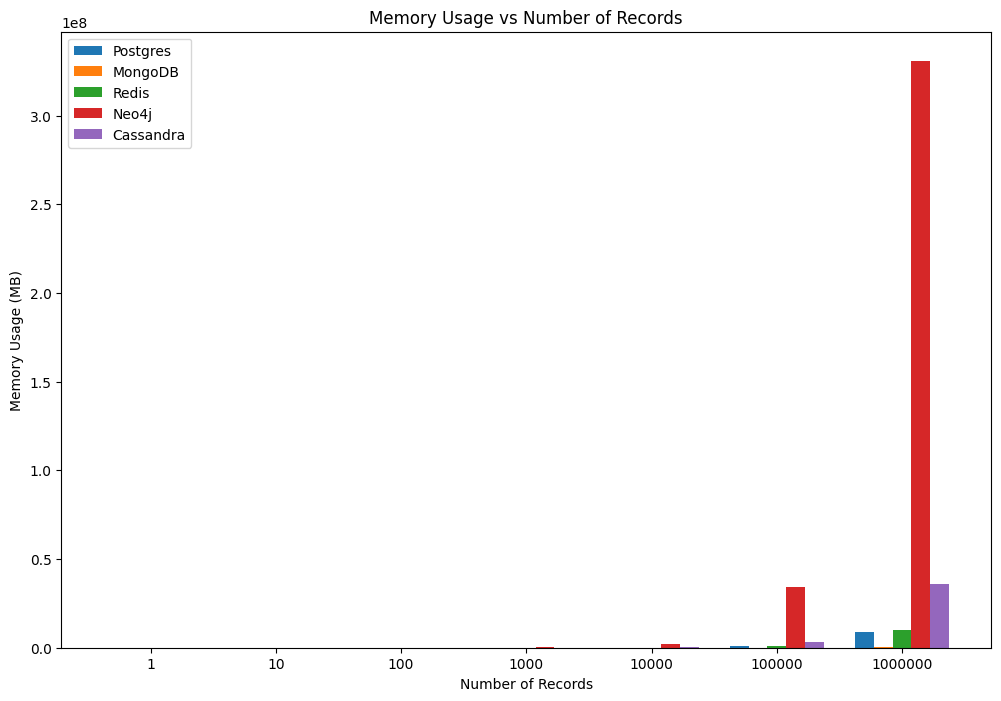

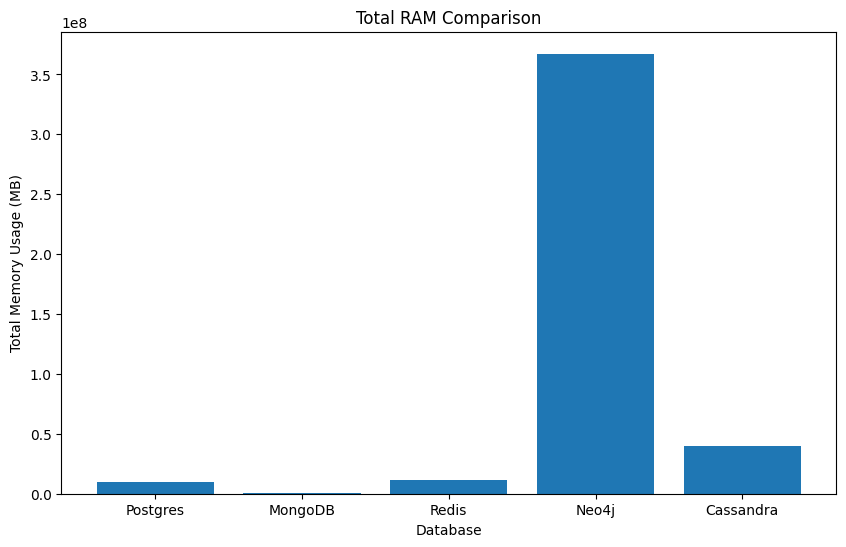

In [16]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Function to load data from CSV file
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Postgres: Insert data
def insert_postgres(data, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        cur.execute("INSERT INTO train_clicks (queryid, timeframe, itemid) VALUES (%s, %s, %s)",
                    (int(row['queryid']), str(row['timeframe']), int(row['itemid'])))
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Insert data
def insert_mongodb(data, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    collection.insert_many(data.to_dict('records'))
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Insert data
def insert_redis(data):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Insert data
def insert_neo4j(data, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for index, row in data.iterrows():
        session.run("CREATE (e:Event {queryid: $queryid, timeframe: $timeframe, itemid: $itemid})", 
                    {'queryid': str(row['queryid']), 'timeframe': str(row['timeframe']), 'itemid': str(row['itemid'])})
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Insert data
def insert_cassandra(data, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for index, row in data.iterrows():
        session.execute(f"""
        INSERT INTO {keyspace}.{table} (queryid, timeframe, itemid) VALUES (%s, %s, %s)
        """, (str(row['queryid']), str(row['timeframe']), str(row['itemid'])))
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'diginetica',
    'table': 'train_clicks'
}

# Load data from CSV file
file_path = 'train-clicks.csv'
data = load_data(file_path)

# Determine the number of rows
total_rows = 1000000

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(0, len(str(total_rows)))]
if total_rows not in record_factors:
    record_factors.append(total_rows)

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    subset_data = data.head(rows)
    
    time_taken, cpu_time, memory_usage = insert_postgres(subset_data, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_mongodb(subset_data, 'diginetica', 'train_clicks')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_redis(subset_data)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_neo4j(subset_data, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_cassandra(subset_data, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig(f'diginetica_insertion_graph_one.png')  # Save the plot
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.savefig('diginetica_insertion_memory_usage_vs_records.png')  # Save the plot
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.savefig('diginetica_insertion_total_ram_comparison.png')  # Save the plot
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('diginetica_insertion_results_train_clicks.csv')



#### 4.2.2. Batch Insertion in Diginetica Dataset

/tmp/ipykernel_26296/1226365495.py:102: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1226365495.py:102: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1226365495.py:102: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1226365495.py:102: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
/tmp/ipykernel_26296/1226365495.py:102: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items

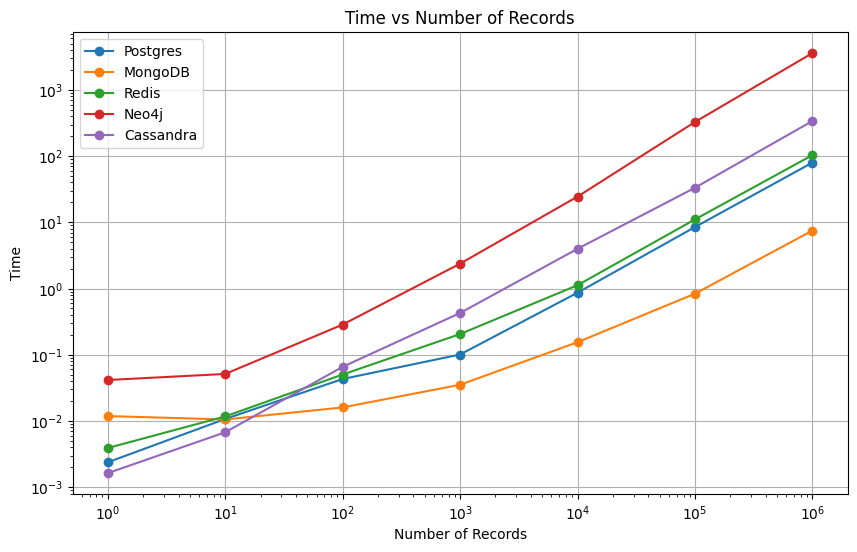

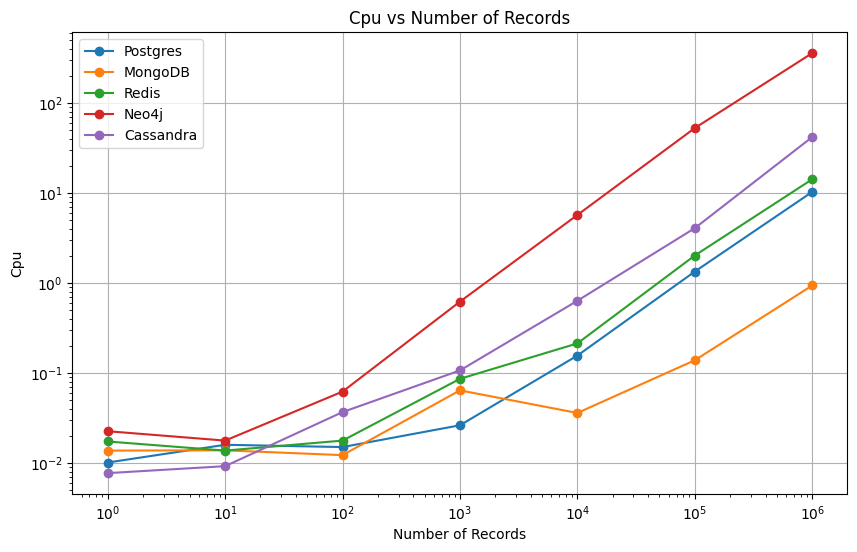

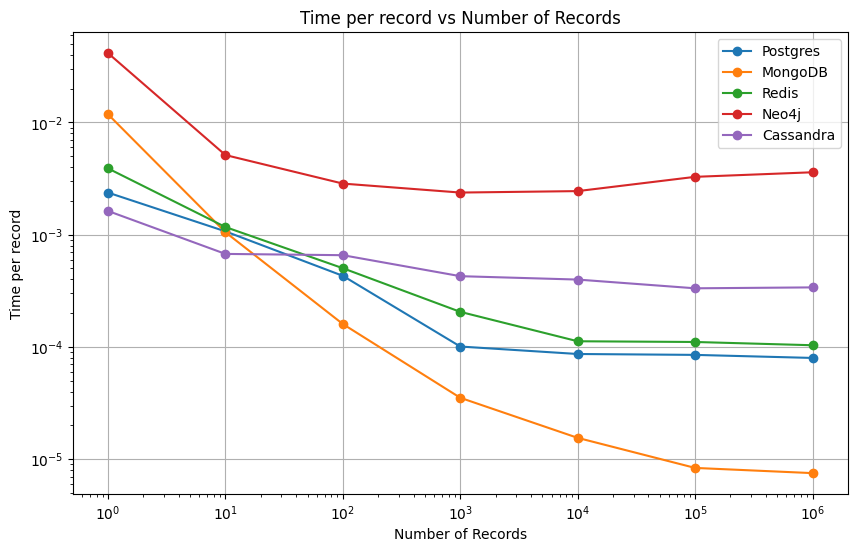

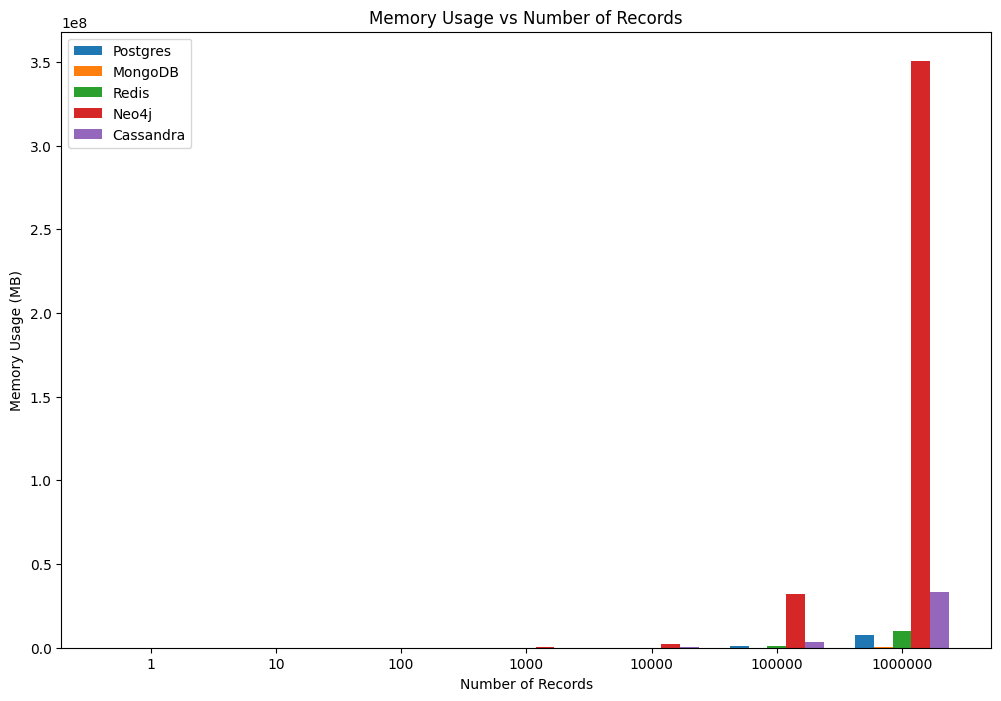

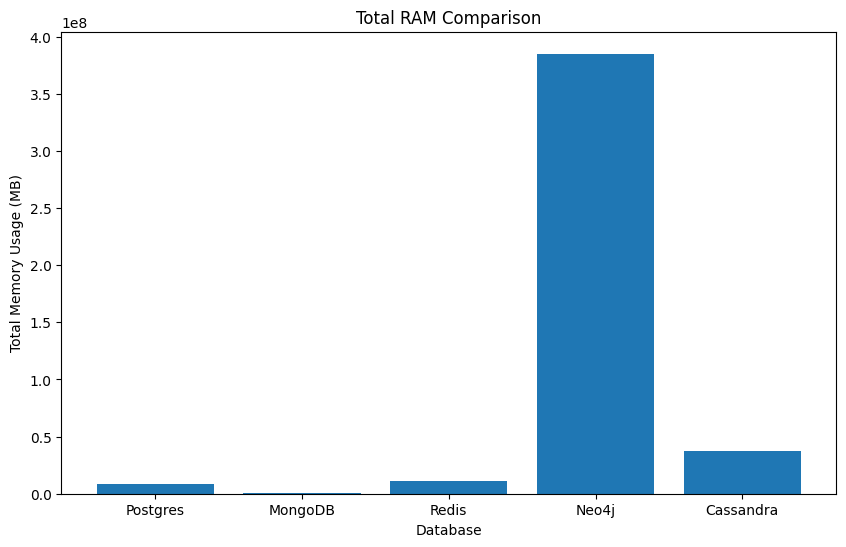

In [24]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Function to load data from CSV file
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Batch size for bulk insertion
BATCH_SIZE = 1000

# Postgres: Insert data
def insert_postgres(data, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for start in range(0, len(data), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(data))
        batch = data.iloc[start:end]
        args = [(int(row['queryid']), str(row['timeframe']), int(row['itemid'])) for _, row in batch.iterrows()]
        cur.executemany("INSERT INTO train_clicks (queryid, timeframe, itemid) VALUES (%s, %s, %s)", args)
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Insert data
def insert_mongodb(data, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for start in range(0, len(data), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(data))
        batch = data.iloc[start:end].to_dict('records')
        collection.insert_many(batch)
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Insert data
def insert_redis(data):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for start in range(0, len(data), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(data))
        batch = data.iloc[start:end]
        for index, row in batch.iterrows():
            redis_client.hmset(f"event:{index}", {k: str(v) for k, v in row.to_dict().items()})
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Insert data
def insert_neo4j(data, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for start in range(0, len(data), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(data))
        batch = data.iloc[start:end]
        for index, row in batch.iterrows():
            session.run("CREATE (e:Event {queryid: $queryid, timeframe: $timeframe, itemid: $itemid})", 
                        {'queryid': str(row['queryid']), 'timeframe': str(row['timeframe']), 'itemid': str(row['itemid'])})
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Insert data
def insert_cassandra(data, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for start in range(0, len(data), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(data))
        batch = data.iloc[start:end]
        for index, row in batch.iterrows():
            session.execute(f"""
            INSERT INTO {keyspace}.{table} (queryid, timeframe, itemid) VALUES (%s, %s, %s)
            """, (str(row['queryid']), str(row['timeframe']), str(row['itemid'])))
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'diginetica',
    'table': 'train_clicks'
}

# Load data from CSV file
file_path = 'train-clicks.csv'
data = load_data(file_path)

# Determine the number of rows
total_rows = 1000000

# Factors of 10 for number of records (rows)
record_factors = [10**i for i in range(0, int(np.log10(total_rows)) + 1)]

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    subset_data = data.head(rows)
    
    time_taken, cpu_time, memory_usage = insert_postgres(subset_data, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_mongodb(subset_data, 'diginetica', 'train_clicks')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_redis(subset_data)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
        
    time_taken, cpu_time, memory_usage = insert_neo4j(subset_data, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage = insert_cassandra(subset_data, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig(f'diginetica_batch_insertion_graph_one.png')  # Save the plot
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.savefig('diginetica_batch_insertion_memory_usage_vs_records.png')  # Save the plot
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.savefig('diginetica_batch_insertion_total_ram_comparison.png')  # Save the plot
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('diginetica_batch_insertion_results_train_clicks.csv')



### 4.3. Reading Diginetica Dataset

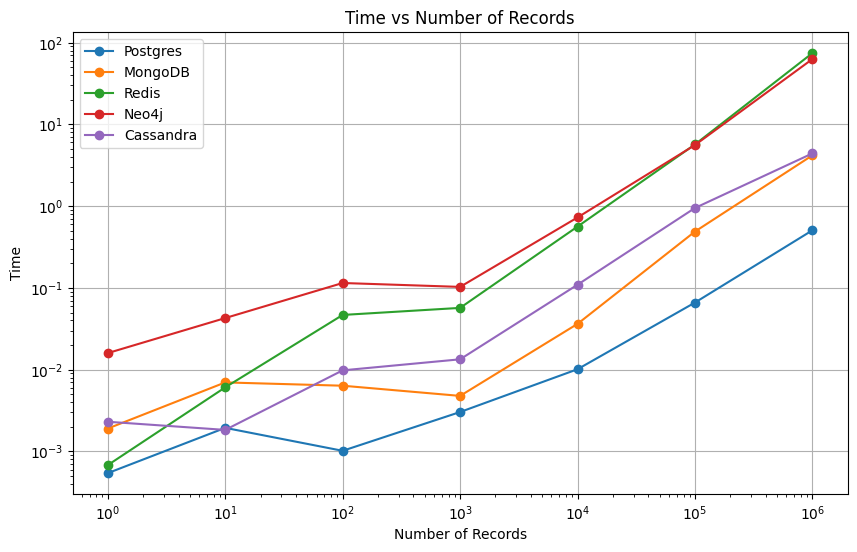

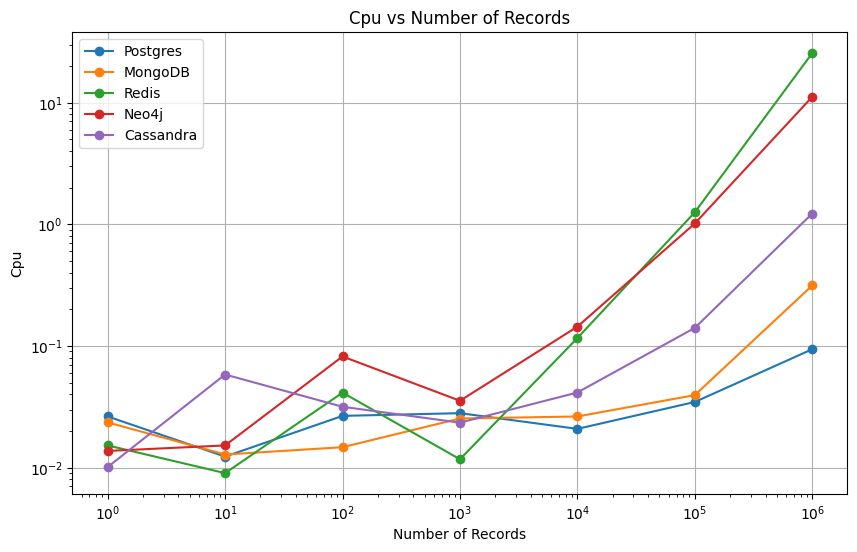

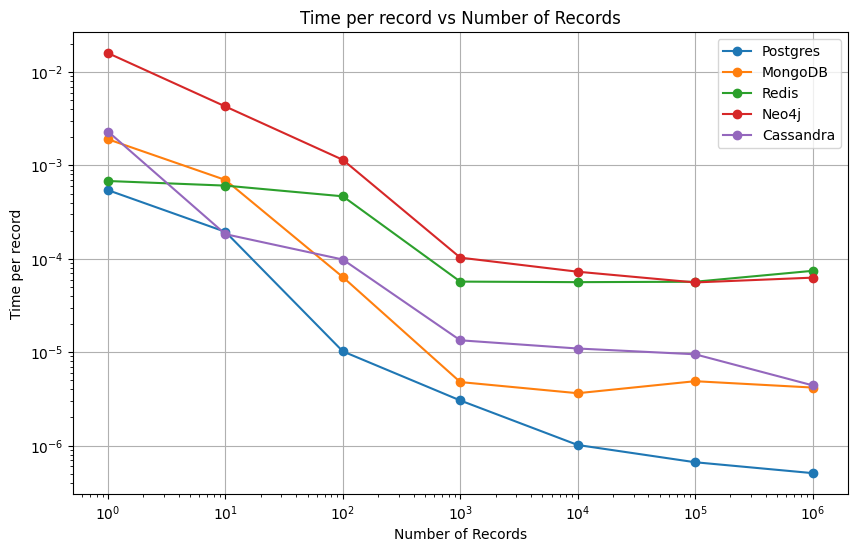

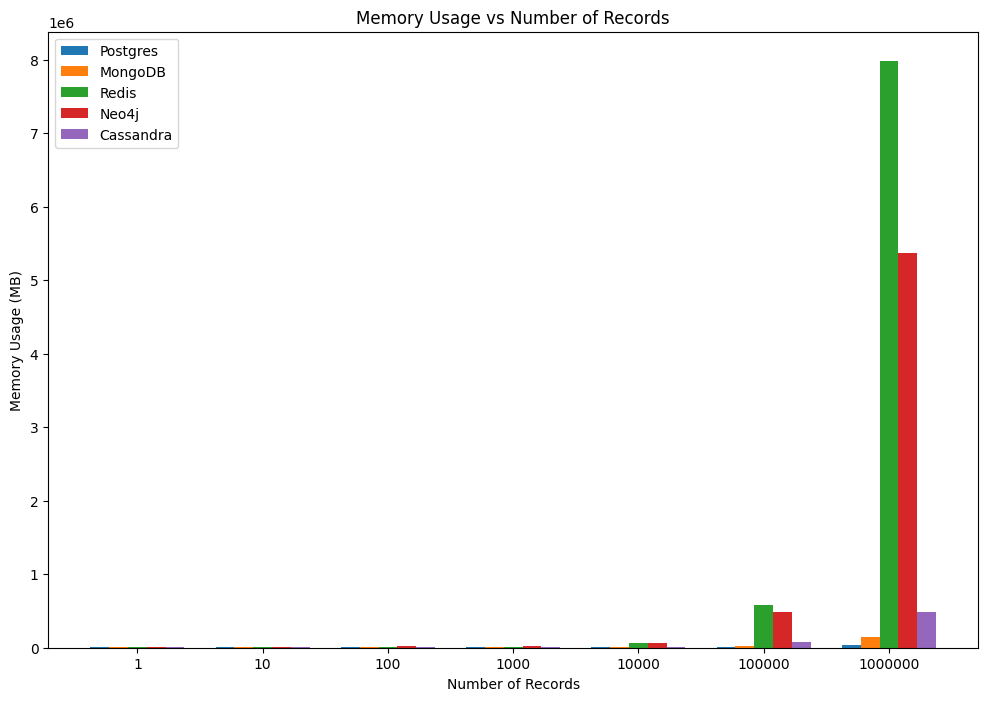

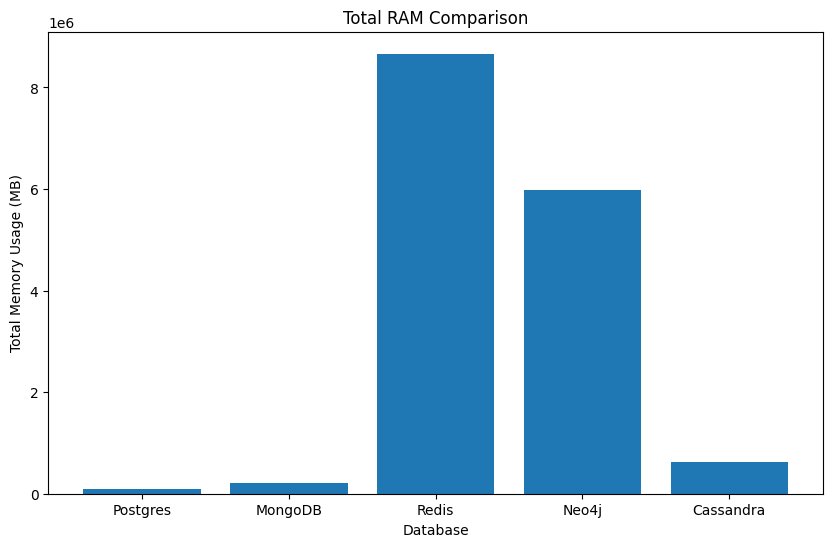

In [19]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Postgres: Read data
def read_postgres(db_params, rows):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute(f"SELECT * FROM train_clicks LIMIT {rows};")
    data = cur.fetchall()
    
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage, data

# MongoDB: Read data
def read_mongodb(db_name, collection_name, rows):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    data = list(collection.find().limit(rows))
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage, data

# Redis: Read data
def read_redis(rows):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    data = []
    for index in range(rows):
        data.append(redis_client.hgetall(f"event:{index}"))
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage, data

# Neo4j: Read data
def read_neo4j(uri, user, password, rows):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    result = session.run(f"MATCH (e:Event) RETURN e LIMIT {rows}")
    data = [record['e'] for record in result]
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage, data

# Cassandra: Read data
def read_cassandra(keyspace, table, rows):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    data = session.execute(f"SELECT * FROM {keyspace}.{table} LIMIT {rows}").all()
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage, data

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'diginetica',
    'table': 'train_clicks'
}


# Determine the number of rows
total_rows = 1000000  #data.shape[0]

# Factors of 10 for number of records (rows), but stop at total_rows
record_factors = [10**i for i in range(0, int(np.log10(total_rows)) + 1)]
if total_rows not in record_factors:
    record_factors.append(total_rows)

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for rows in record_factors:
    time_taken, cpu_time, memory_usage, data = read_postgres(db_params, rows)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage, data = read_mongodb('diginetica', 'train_clicks', rows)
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage, data = read_redis(rows)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage, data = read_neo4j(**neo4j_params, rows=rows)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / rows)
    
    time_taken, cpu_time, memory_usage, data = read_cassandra(**cassandra_params, rows=rows)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / rows)

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig(f'diginetica_read_graph_one.png')  # Save the plot
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.savefig('diginetica_read_memory_usage_vs_records.png')  # Save the plot
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.savefig('diginetica_read_total_ram_comparison.png')  # Save the plot
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('diginetica_read_results_train_clicks.csv')



#### 4.4. Updating Diginetica Database

For PostgreSQL, MongoDB, Redis, Neo4j, and Cassandra, the fields timeframe and itemid are converted to strings before concatenation to avoid the TypeError.

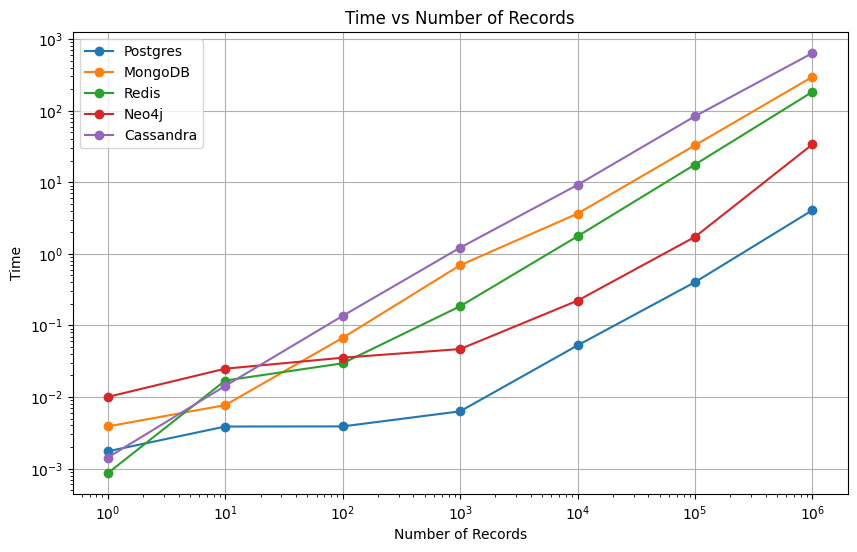

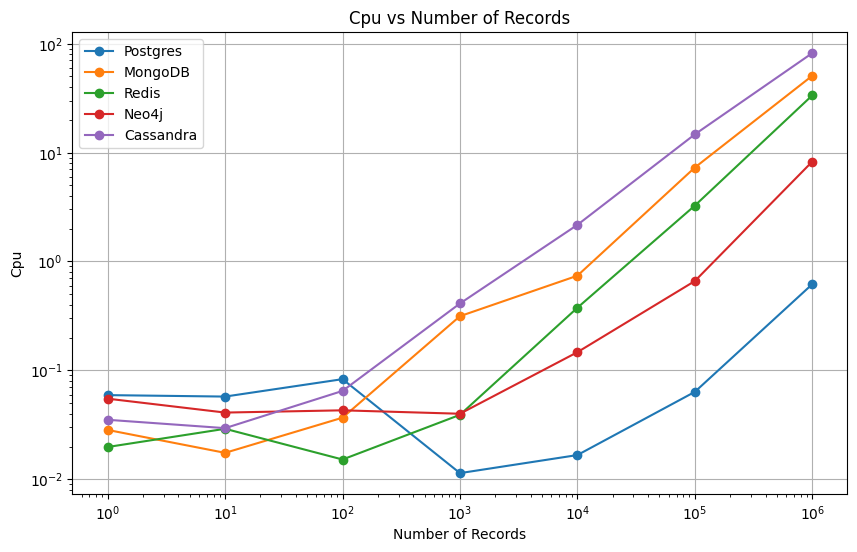

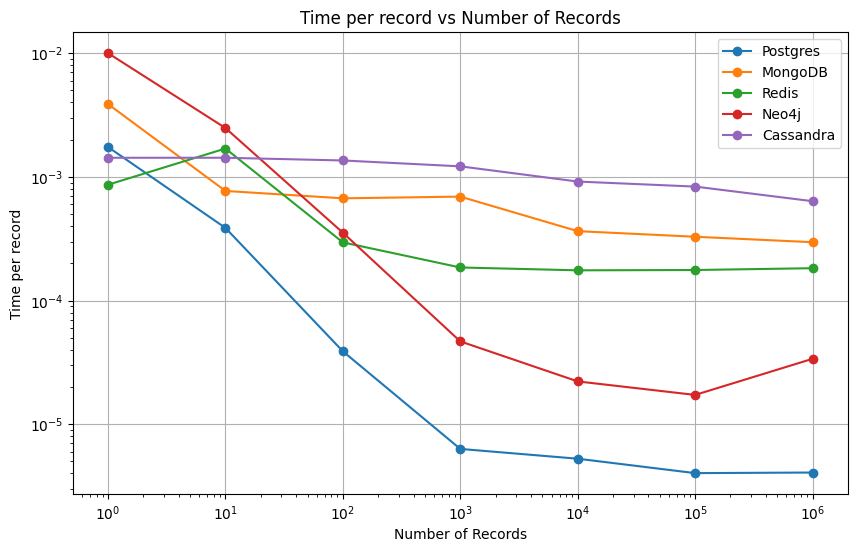

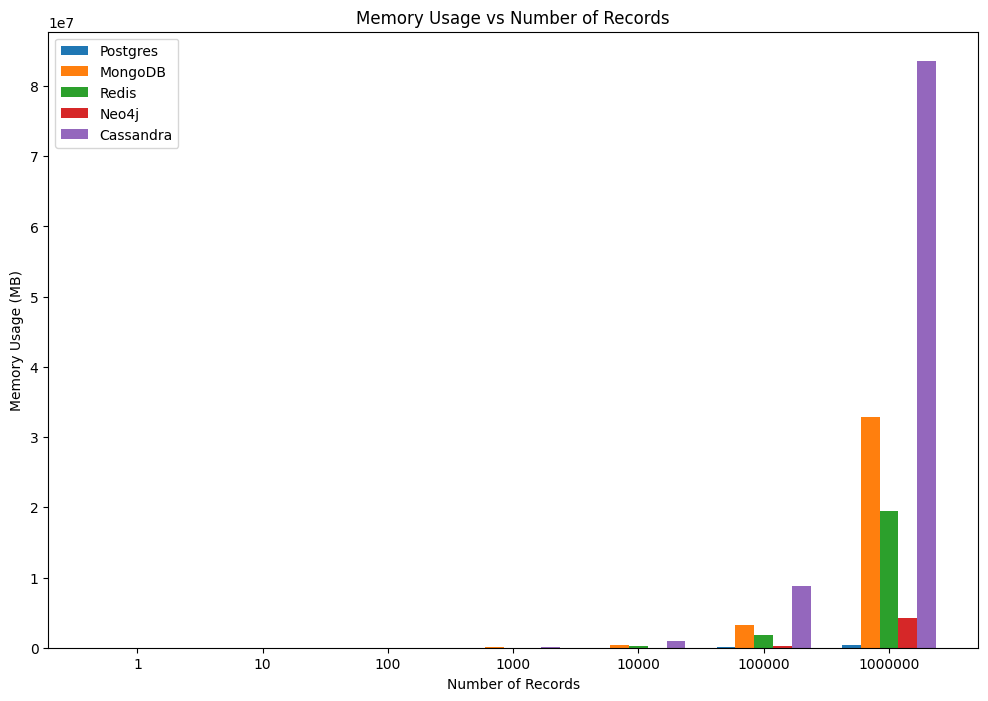

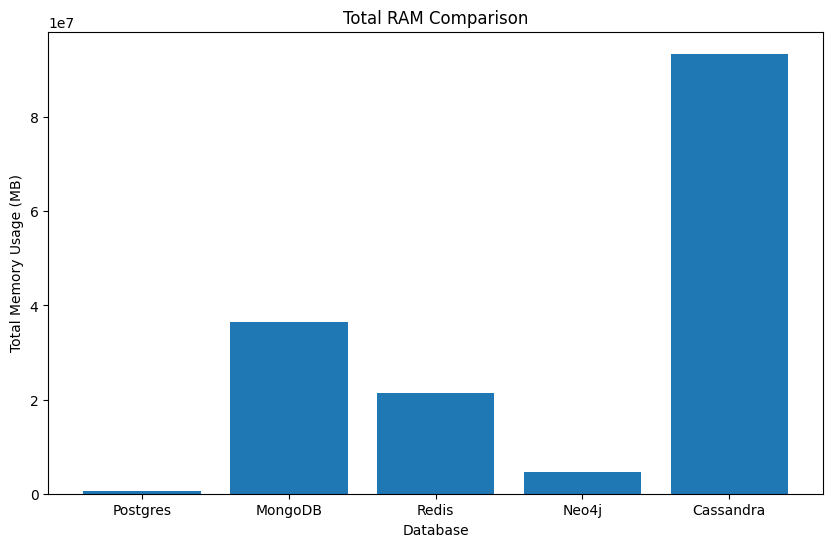

In [33]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Variable to set the maximum number of records to be updated
max_records_to_update = 1000000

# Generate record factors
record_factors = [10**i for i in range(0, int(np.log10(max_records_to_update)) + 1)]

# Postgres: Update data
def update_postgres(num_records, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute(f"""
        UPDATE train_clicks 
        SET 
            timeframe = timeframe || '_updated', 
            itemid = itemid || '_updated'
        WHERE ctid IN (SELECT ctid FROM train_clicks LIMIT {num_records})
    """)
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Update data
def update_mongodb(num_records, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    records = list(collection.find().limit(num_records))
    for record in records:
        collection.update_one({'_id': record['_id']}, {'$set': {'timeframe': str(record['timeframe']) + '_updated', 'itemid': str(record['itemid']) + '_updated'}})
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Update data
def update_redis(num_records):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for i in range(num_records):
        key = f"event:{i}"
        redis_client.hset(key, 'timeframe', str(redis_client.hget(key, 'timeframe')) + '_updated')
        redis_client.hset(key, 'itemid', str(redis_client.hget(key, 'itemid')) + '_updated')
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Update data
def update_neo4j(num_records, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    session.run(f"MATCH (e:Event) WITH e LIMIT {num_records} SET e.timeframe = toString(e.timeframe) + '_updated', e.itemid = toString(e.itemid) + '_updated'")
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Update data
def update_cassandra(num_records, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for i in range(num_records):
        # Read current values
        result = session.execute(f"SELECT timeframe, itemid FROM {keyspace}.{table} WHERE queryid = %s", (str(i),)).one()
        if result:
            current_timeframe = result.timeframe
            current_itemid = result.itemid

            # Update with appended values
            session.execute(f"""
            UPDATE {keyspace}.{table} 
            SET timeframe = %s, itemid = %s 
            WHERE queryid = %s
            """, (current_timeframe + '_updated', current_itemid + '_updated', str(i)))
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'diginetica',
    'table': 'train_clicks'
}

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for records in record_factors:
    time_taken, cpu_time, memory_usage = update_postgres(records, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = update_mongodb(records, 'diginetica', 'train_clicks')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = update_redis(records)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = update_neo4j(records, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = update_cassandra(records, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / records)

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig(f'diginetica_update_{metric}_graph.png')  # Save the plot
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.savefig('diginetica_update_memory_usage_vs_records.png')  # Save the plot
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.savefig('diginetica_update_total_ram_comparison.png')  # Save the plot
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('diginetica_update_results_train_clicks.csv')


### 4.5. Deleting Diginetica Database

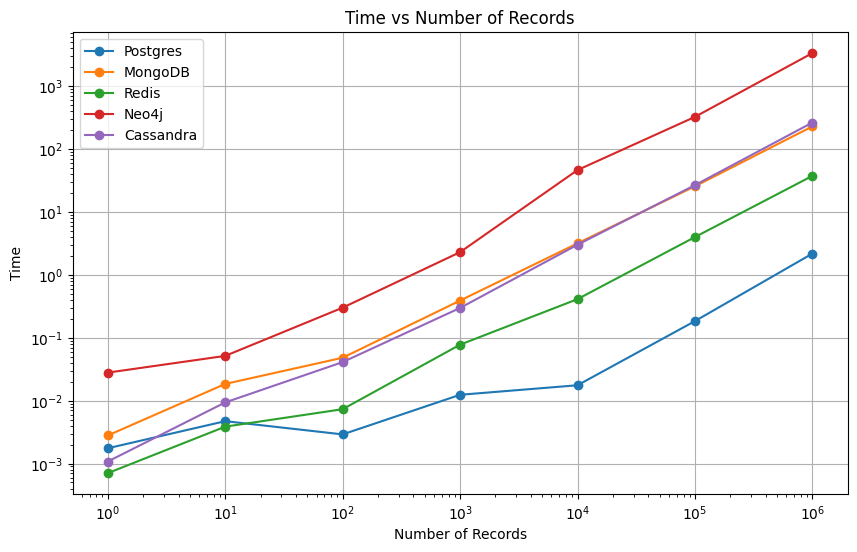

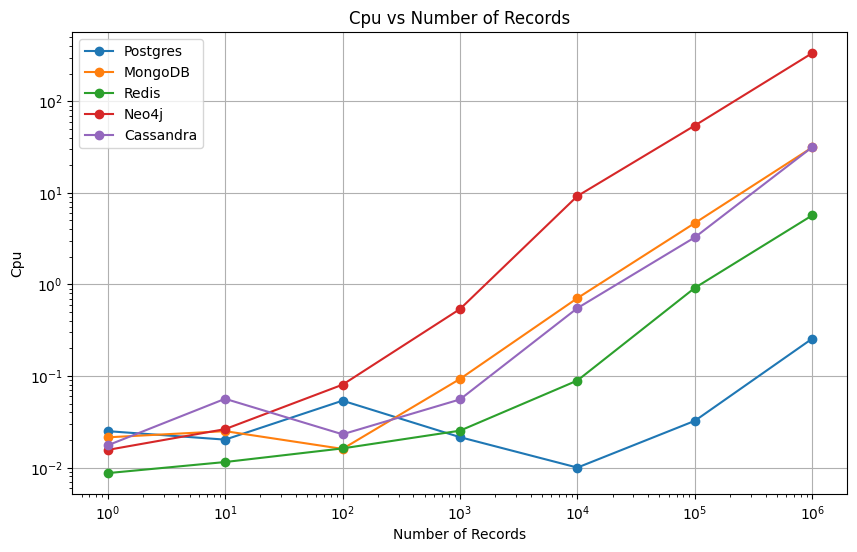

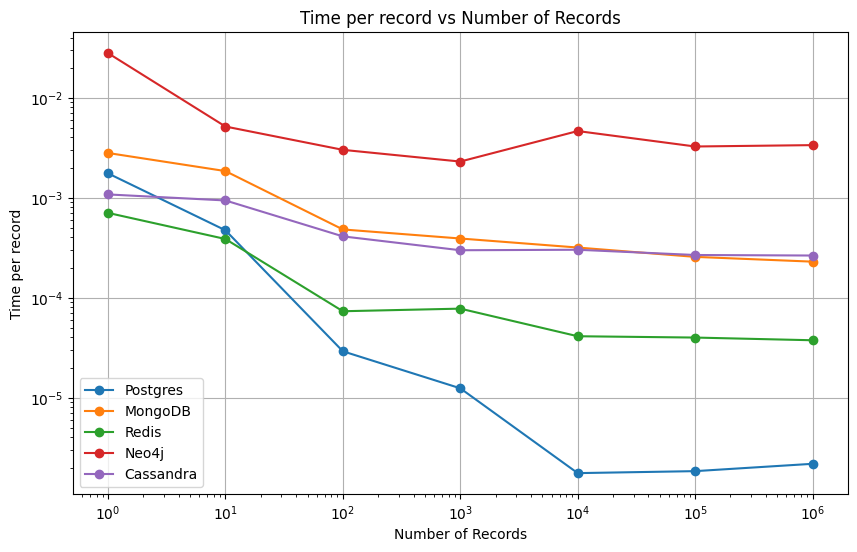

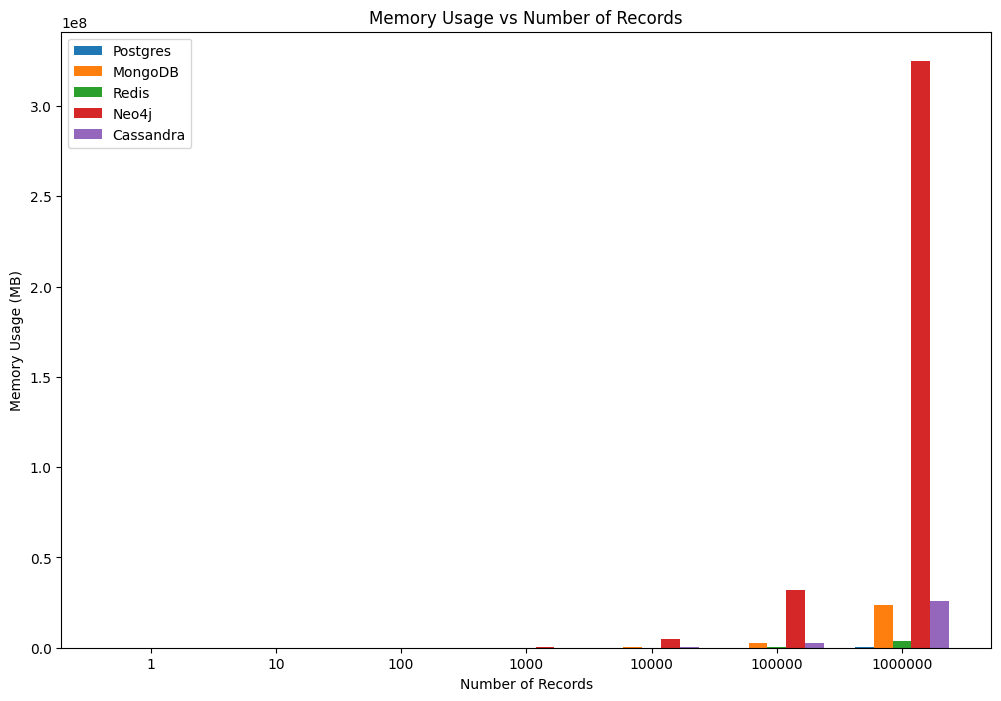

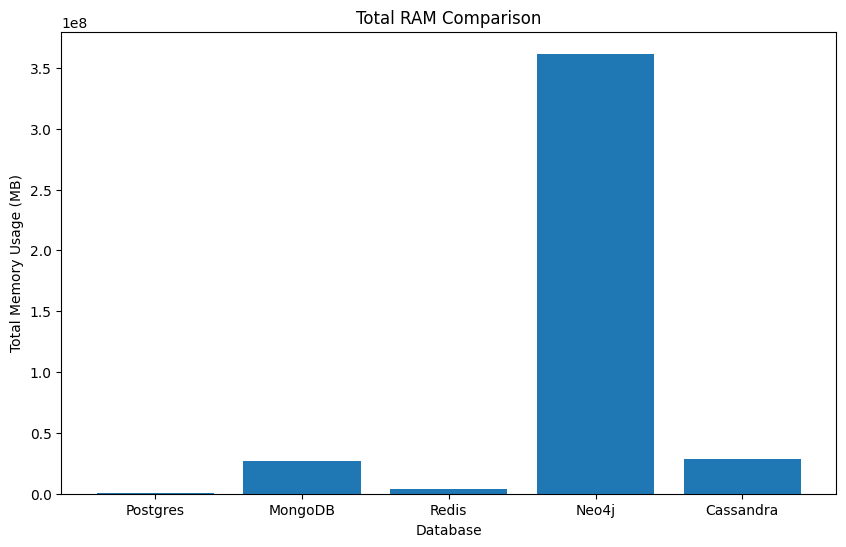

In [23]:
# Function to monitor resource utilization
def monitor_resources(stop_event, resource_queue, interval=0.1):
    total_cpu_time = 0
    total_memory_usage = 0
    while not stop_event.is_set():
        total_cpu_time += psutil.cpu_percent(interval=interval) * interval / 100.0  # Convert to CPU time in seconds
        total_memory_usage += psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
    resource_queue.put((total_cpu_time, total_memory_usage))

# Variable to set the maximum number of records to be deleted
max_records_to_delete = 1000000

# Generate record factors
record_factors = [10**i for i in range(0, int(np.log10(max_records_to_delete)) + 1)]

# Postgres: Delete data
def delete_postgres(num_records, db_params):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    cur.execute(f"DELETE FROM train_clicks WHERE ctid IN (SELECT ctid FROM train_clicks LIMIT {num_records})")
    
    conn.commit()
    end_time = time.time()
    conn.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# MongoDB: Delete data
def delete_mongodb(num_records, db_name, collection_name):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client[db_name]
    collection = db[collection_name]
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    records = list(collection.find().limit(num_records))
    for record in records:
        collection.delete_one({'_id': record['_id']})
    
    end_time = time.time()
    client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Redis: Delete data
def delete_redis(num_records):
    redis_client = redis.Redis(host='localhost', port=6379, decode_responses=True)
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for i in range(num_records):
        key = f"event:{i}"
        redis_client.delete(key)
    
    end_time = time.time()
    redis_client.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Neo4j: Delete data
def delete_neo4j(num_records, uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    session = driver.session()
    
    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()
    
    start_time = time.time()
    
    for i in range(num_records):
        session.run("MATCH (e:Event) WITH e LIMIT 1 DELETE e")
    
    end_time = time.time()
    session.close()
    driver.close()
    
    stop_event.set()
    monitor_thread.join()
    
    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Cassandra: Delete data
def delete_cassandra(num_records, keyspace, table):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider, protocol_version=4, connect_timeout=60)
    session = cluster.connect()
    session.default_timeout = 36000  # setting the default timeout for cassandra to 10 hours
    session.default_request_timeout = 36000  # setting the request timeout to a higher value

    stop_event = threading.Event()
    resource_queue = Queue()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event, resource_queue))
    monitor_thread.start()

    start_time = time.time()
    
    for i in range(num_records):
        session.execute(f"DELETE FROM {keyspace}.{table} WHERE queryid = %s", (str(i),))
    
    end_time = time.time()
    cluster.shutdown()

    stop_event.set()
    monitor_thread.join()

    total_cpu_time, total_memory_usage = resource_queue.get()
    return end_time - start_time, total_cpu_time, total_memory_usage

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'QWERTY'
}

neo4j_params = {
    'uri': 'neo4j://localhost:7687',
    'user': 'neo4j',
    'password': 'QWERTY'
}

cassandra_params = {
    'keyspace': 'diginetica',
    'table': 'train_clicks'
}

results = {'Postgres': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'MongoDB': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Redis': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Neo4j': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []},
           'Cassandra': {'time': [], 'cpu': [], 'memory': [], 'time_per_record': []}}

for records in record_factors:
    time_taken, cpu_time, memory_usage = delete_postgres(records, db_params)
    results['Postgres']['time'].append(time_taken)
    results['Postgres']['cpu'].append(cpu_time)
    results['Postgres']['memory'].append(memory_usage)
    results['Postgres']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = delete_mongodb(records, 'diginetica', 'train_clicks')
    results['MongoDB']['time'].append(time_taken)
    results['MongoDB']['cpu'].append(cpu_time)
    results['MongoDB']['memory'].append(memory_usage)
    results['MongoDB']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = delete_redis(records)
    results['Redis']['time'].append(time_taken)
    results['Redis']['cpu'].append(cpu_time)
    results['Redis']['memory'].append(memory_usage)
    results['Redis']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = delete_neo4j(records, **neo4j_params)
    results['Neo4j']['time'].append(time_taken)
    results['Neo4j']['cpu'].append(cpu_time)
    results['Neo4j']['memory'].append(memory_usage)
    results['Neo4j']['time_per_record'].append(time_taken / records)

    time_taken, cpu_time, memory_usage = delete_cassandra(records, **cassandra_params)
    results['Cassandra']['time'].append(time_taken)
    results['Cassandra']['cpu'].append(cpu_time)
    results['Cassandra']['memory'].append(memory_usage)
    results['Cassandra']['time_per_record'].append(time_taken / records)

# Plot results
for metric in ['time', 'cpu', 'time_per_record']:
    plt.figure(figsize=(10, 6))
    for db in results.keys():
        plt.plot(record_factors, results[db][metric], marker='o', label=db)
    plt.xlabel('Number of Records')
    plt.ylabel(f'{metric.replace("_", " ").capitalize()}')
    plt.title(f'{metric.replace("_", " ").capitalize()} vs Number of Records')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig(f'diginetica_delete_graph_one.png')  # Save the plot
    plt.show()

# Memory Usage vs Number of Records Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
index = np.arange(len(record_factors))

for i, db in enumerate(results.keys()):
    ax.bar(index + i * bar_width, results[db]['memory'], bar_width, label=db)

ax.set_xlabel('Number of Records')
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage vs Number of Records')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(record_factors)
ax.legend()
plt.savefig('diginetica_delete_memory_usage_vs_records.png')  # Save the plot
plt.show()

# Total RAM Comparison Bar Plot
total_memory = {db: sum(results[db]['memory']) for db in results.keys()}
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(total_memory.keys(), total_memory.values())
ax.set_xlabel('Database')
ax.set_ylabel('Total Memory Usage (MB)')
ax.set_title('Total RAM Comparison')
plt.savefig('diginetica_delete_total_ram_comparison.png')  # Save the plot
plt.show()

# Save results to CSV
df_results = pd.DataFrame({f'{metric}_{db}': results[db][metric] for db in results.keys() for metric in results[db].keys()}, index=record_factors)
df_results.to_csv('diginetica_delete_results_train_clicks.csv')



## 5. Neo4j Based Recommeder System

Movie lens database will be used for creation of this recommender system

### 5.1. Importing Libararies 

In [3]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience
from neo4j import GraphDatabase

### 5.2. Connecting to Neo4j Sandbox

In [4]:
# Neo4j Connection details
DB_ULR = 'bolt://44.211.212.216:7687'
DB_USER = 'neo4j'
DB_PASS = 'decision-element-discount'
gds = GraphDataScience(DB_ULR, auth=(DB_USER, DB_PASS))
gds.version()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


'2.6.7'

### 5.3. Creating User and Movie nodes in the database

In [17]:
movies = pd.read_csv('movies.dat',sep='::',encoding = "ISO-8859-1",names=['MovieID','Title','Genres'])
ratings = pd.read_csv('ratings.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','MovieID','Rating','Timestamp'])
users = pd.read_csv('users.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','Gender','Age','Occupation','Zip_code'])

C:\Users\hp\AppData\Local\Temp\ipykernel_16952\2992453101.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('movies.dat',sep='::',encoding = "ISO-8859-1",names=['MovieID','Title','Genres'])
C:\Users\hp\AppData\Local\Temp\ipykernel_16952\2992453101.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('ratings.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','MovieID','Rating','Timestamp'])
C:\Users\hp\AppData\Local\Temp\ipykernel_16952\2992453101.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separato

In [18]:
# Create user nodes
gds.run_cypher('create constraint if not exists for (n:User) require (n.id) is node key')
create_customer_res = gds.run_cypher('''
    unwind $data as row
    merge (n:User{id: row.UserID})
    set n.Gender = row.Gender
    set n.Age =  row.Age 
    return count(*) as custmers_created
''', params = {'data': users.to_dict('records')})
create_customer_res.head()

,custmers_created
0,6040


In [19]:
# Create movies nodes
gds.run_cypher('create constraint if not exists for (n:Movie) require (n.id) is node key')
create_customer_res = gds.run_cypher('''
    unwind $data as row
    merge (n:Movie{id: row.MovieID})
    set n.Title = row.Title
    set n.Genres =  row.Genres 
    return count(*) as movies_created
''', params = {'data': movies.to_dict('records')})
create_customer_res.head()

,movies_created
0,3883


### 5.4. Creating Relationships

Ratings data frame is quite large, hence it is split in chunks and then uploaded.

In [20]:
# Create rated relationship
i=1
for chunk in np.array_split(ratings,200):
  if i%10 == 0:
    print(i)
  create_rated = gds.run_cypher('''
    unwind $data as row
    match (u:User{id: row.UserID}), (m:Movie{id: row.MovieID})
    merge (u)-[r:RATED]->(m)
    set r.Rating = row.Rating
    return count(*) as create_rated
    ''', params = {'data': chunk.to_dict('records')})
  i = i+1
create_rated.head()

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


,create_rated
0,5001


In [22]:
# Function to connect to Neo4j and print the count of all relationships
def print_relationship_count(DB_ULR, DB_USER, DB_PASS):
    driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS))
    session = driver.session()
    
    result = session.run("MATCH ()-[r]->() RETURN COUNT(r) AS relationship_count")
    for record in result:
        print(f"Total Relationships: {record['relationship_count']}")
    
    session.close()
    driver.close()

# Connect to Neo4j and print the count of all relationships
print_relationship_count('bolt://44.211.212.216:7687', 'neo4j', 'decision-element-discount')


Total Relationships: 1000209


### 5.5. Generating Recommendations

#### 5.5.1. Movie-Movie Similarity

Based on count of common users who have rated the similar movies.
$(movie_1)-[]\rightarrow(user)-[]\rightarrow(movie_2)$  
Here, movie1 is the movie we want to find similar movies for. For example - 'Toy Story (1995)'.
-  Note: Below code focus on such users who have rated both movie 5.

In [23]:
# Check similar movies
similar_movies = gds.run_cypher('''
    MATCH(m1:Movie)-[r1]-(u:User)-[r2]-(m2:Movie)
    WHERE m1.Title CONTAINS 'Toy Story (1995)'
      AND m2.Title<>'Toy Story (1995)'
      AND r1.Rating=5 AND r2.Rating=5
    RETURN m2.Title,m2.Genres,count(DISTINCT(u)) as common_users
    ORDER BY common_users DESC
''')
similar_movies.head()

,m2.Title,m2.Genres,common_users
0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,401
1,Toy Story 2 (1999),Animation|Children's|Comedy,385
2,Raiders of the Lost Ark (1981),Action|Adventure,373
3,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,346
4,"Shawshank Redemption, The (1994)",Drama,327


#### 5.5.2. User Based Recommendations using Jaccard Similarity

First step is to use jaccard similarity score between users. A Graph Projection (virtual subgraph) from data in Neo4j database is created. So, The following steps are used:
- Creating Projection named 'MyGraph'
- Calculating Jaccard Similarity

##### 5.5.2.1. Creating Projection

In [24]:
# Create projection
create_projection = gds.run_cypher('''
   CALL gds.graph.project(
    'myGraph',
    ['User', 'Movie'],
    {
        RATED: {properties:  'Rating'}
            } 
);
''')
create_projection.head()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'User': {'label': 'User', 'properties': {}}, ...","{'RATED': {'aggregation': 'DEFAULT', 'orientat...",myGraph,9923,1000209,14605


##### 5.5.2.2. Calculating Jaccard Similarity

In [5]:
# Get user similarity
users_similarity = gds.run_cypher('''
CALL gds.nodeSimilarity.stream('myGraph')
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS UserID1, gds.util.asNode(node2).id AS UserID2, similarity
ORDER BY similarity DESCENDING, UserID1, UserID2
''')
users_similarity.head()

,UserID1,UserID2,similarity
0,4725,4808,0.755415
1,4808,4725,0.755415
2,1122,2126,0.632000
3,2126,1122,0.632000
4,1272,2837,0.601852


![alt text](similaruser4725.png)

Next, we create a new relationship between users. Similarity score between them is add as an attribute.

In [26]:
# Create Similar relationship
i=1
for chunk in np.array_split(users_similarity.query('UserID1>UserID2'),10):
  print(i)
  create_similar = gds.run_cypher('''
    unwind $data as row
    match (u1:User{id: row.UserID1}), (u2:User{id: row.UserID2})
    merge (u1)-[r:SIMILAR]->(u2)
    set r.Similarity=row.similarity
    return count(*) as create_rated
    ''', params = {'data': chunk.to_dict('records')})
  i = i+1
create_similar.head()

1
2
3
4
5
6
7
8
9
10


,create_rated
0,3179


In order to recommend movies to user1, we:   
1. find similar users and then movies they have rated
2. for each movie we found in step (1), we calculate average rating weighted by similarity score:  
$ r_{m,avg}=\frac{1}{\sum s_{user_2}}\sum s_{user_2}r_{m}$   
where sum runs over all paths   
$ (user_1)-[s_{user_2}]-(user_2)-[r_m]→(movie)$  

In the implementation below, we add term $log(number\_of\_paths)$ to boost movies that are connected to $user_1$ throught multiple such paths. 

In [61]:
# Check similar movies
similar_movies_for_user = gds.run_cypher('''
    MATCH (u1:User)-[r1:SIMILAR]-(u2)-[r2:RATED]-(m:Movie)
    WHERE id(u1)=$id
    AND NOT ( (u1)-[]-(m))
    RETURN m.Title,m.Genres,Sum(r1.Similarity*r2.Rating)/sum(r1.Similarity)+log(count(r2)) as score
    ORDER BY score DESC
''',params = {'id':4725})
similar_movies_for_user.head(10)

,m.Title,m.Genres,score
0,Schindler's List (1993),Drama|War,6.864803
1,Toy Story (1995),Animation|Children's|Comedy,6.497486
2,October Sky (1999),Drama,6.390129
3,Almost Famous (2000),Comedy|Drama,6.389066
4,Bulworth (1998),Comedy,6.283263
5,Boys Don't Cry (1999),Drama,6.259083
6,Apollo 13 (1995),Drama,6.209804
7,Boogie Nights (1997),Drama,6.169459
8,GoodFellas (1990),Crime|Drama,6.156693
9,"Simple Plan, A (1998)",Crime|Thriller,6.120458


![alt text](connections.png)

In [62]:
# Check actual movies
movies_for_user = gds.run_cypher('''
    MATCH (u1:User)-[r:RATED]-(m:Movie)
  WHERE id(u1)=$id
  RETURN m.Title,m.Genres,r.Rating as rating
  ORDER BY rating DESC
''',params = {'id':4725})
movies_for_user.head(10)

,m.Title,m.Genres,rating
0,"Crying Game, The (1992)",Drama|Romance|War,5
1,Saving Private Ryan (1998),Action|Drama|War,5
2,Sleepless in Seattle (1993),Comedy|Romance,5
3,"Thomas Crown Affair, The (1999)",Action|Thriller,5
4,"Wrong Trousers, The (1993)",Animation|Comedy,5
5,"Spanish Prisoner, The (1997)",Drama|Thriller,5
6,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical,5
7,You've Got Mail (1998),Comedy|Romance,5
8,Wallace & Gromit: The Best of Aardman Animatio...,Animation,5
9,"Corrina, Corrina (1994)",Comedy|Drama|Romance,5


![alt text](100_rated_user4725.png)

## 6. Conclusion

### 6.1. Comparing Database Results for CRUD Operations

The below code compares the total elapsed time for CRUD operation on Retail Rocket and Diginetica Datasets for 1000000 records. 

C:\Users\hp\AppData\Local\Temp\ipykernel_13016\3195382132.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], x='Database', y='Time', hue='Operation', data=df_retail_melted, ci=None)
C:\Users\hp\AppData\Local\Temp\ipykernel_13016\3195382132.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], x='Database', y='Time', hue='Operation', data=df_diginetica_melted, ci=None)


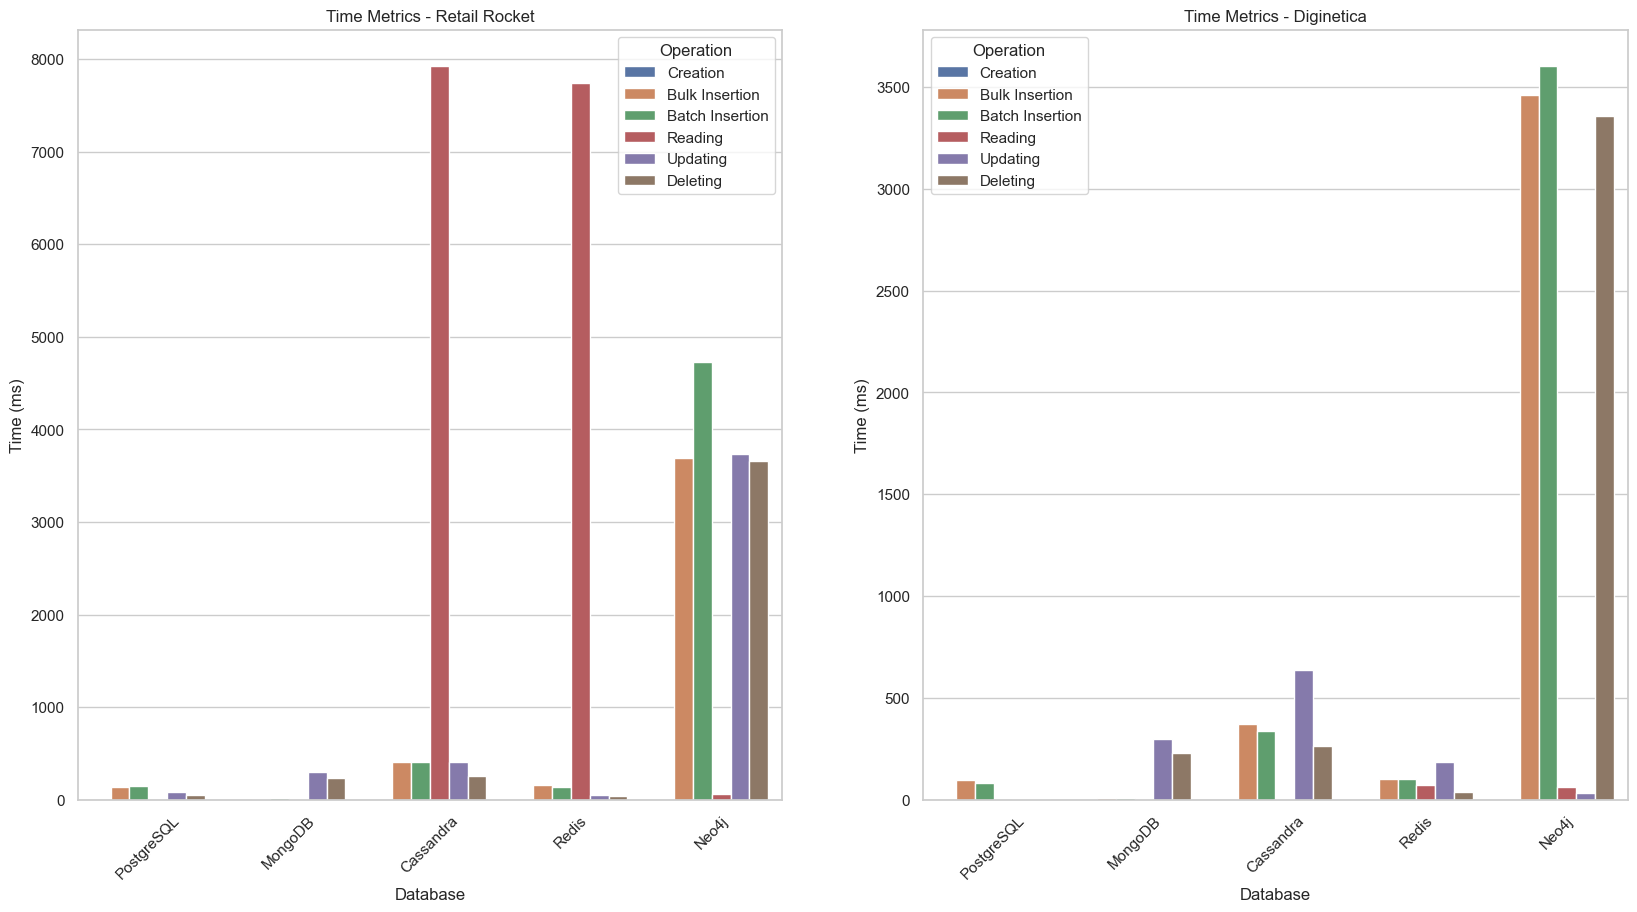

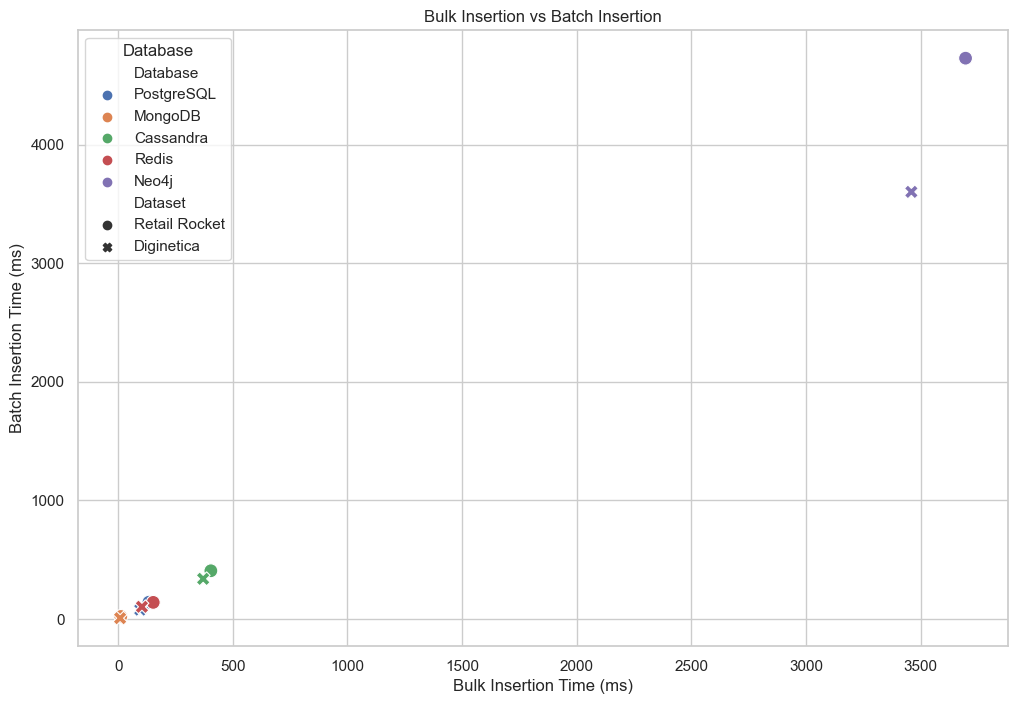

In [3]:
# Load both CSV files
file_path_retail = 'Retail_Rocket_Final.csv'
file_path_diginetica = 'Diginetica_Final.csv'

df_retail = pd.read_csv(file_path_retail)
df_diginetica = pd.read_csv(file_path_diginetica)

# Add a new column to distinguish the datasets
df_retail['Dataset'] = 'Retail Rocket'
df_diginetica['Dataset'] = 'Diginetica'

# Combine the dataframes
df_combined = pd.concat([df_retail, df_diginetica], ignore_index=True)

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Separate bar plots for time metrics comparison for each dataset
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Retail Rocket dataset
df_retail_melted = df_retail.melt(id_vars=['Database'], value_vars=time_metrics, var_name='Operation', value_name='Time')
sns.barplot(ax=axes[0], x='Database', y='Time', hue='Operation', data=df_retail_melted, ci=None)
axes[0].set_title('Time Metrics - Retail Rocket')
axes[0].set_ylabel('Time (ms)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title='Operation')

# Diginetica dataset
df_diginetica_melted = df_diginetica.melt(id_vars=['Database'], value_vars=time_metrics, var_name='Operation', value_name='Time')
sns.barplot(ax=axes[1], x='Database', y='Time', hue='Operation', data=df_diginetica_melted, ci=None)
axes[1].set_title('Time Metrics - Diginetica')
axes[1].set_ylabel('Time (ms)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].legend(title='Operation')

plt.show()

# Combined scatter plot for relationship between Bulk Insertion and Batch Insertion, differentiated by Dataset
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Bulk Insertion', y='Batch Insertion', hue='Database', style='Dataset', data=df_combined, s=100)
plt.title('Bulk Insertion vs Batch Insertion')
plt.xlabel('Bulk Insertion Time (ms)')
plt.ylabel('Batch Insertion Time (ms)')
plt.legend(title='Database')
plt.show()


The performance analysis of CRUD operations on the Retail Rocket and Diginetica datasets underscores MongoDB's superior efficiency in bulk and batch insertions, and PostgreSQL's strength in reading, updating, and deleting operations. Neo4j, while excellent at handling complex relationships, exhibits high memory usage, and Redis is noted for its fast update and deletion times but high memory consumption during reads. These insights enable database administrators and system architects to choose the most suitable database systems for specific applications, optimizing both performance and resource utilization.

### 6.2. Retail Rocket Dataset

#### 6.2.1. Conclusion

Retail Rocket Dataset (events.csv) was successfully used to create database. The database was created in 5 different database management systems - PostgreSQL, MongoDB, Cassandra, Redis and Neo4j. The operations performed included Bulk insertion, Batch insertion, reading, updating and deleting records. Each database type demonstrated different performance characteristics and trade-offs.

##### 6.2.2. Recommendations

For insertion operation, MongoDB is fastest followed by PostgreSQL and Redis. For Reading operation, PostgreSQL and  MongoDB has lowest latency. for updating operation, Redis is fastest & for deletion operation, Redis followed by PostgreSQL are fast.

### 6.3. Diginetica Dataset

#### 6.3.1. Conclusion

Diginetica Dataset (train-clicks.csv) was successfully used to create database. The database was created in 5 different database management systems - PostgreSQL, MongoDB, Cassandra, Redis and Neo4j. The operations performed included Bulk insertion, Batch insertion, reading, updating and deleting records. Each database type demonstrated different performance characteristics and trade-offs.

#### 6.3.2. Recommendations

For insertion operation, MongoDB is fastest followed by PostgreSQL and Redis. For Reading operation, PostgreSQL and  MongoDB has lowest latency. for updating operation, PostgreSQL is fastest & for deletion operation, Postgres followed by Redis are fast.

### 6.4. Neo4j Based Recommender System

A Neo4j-based recommender system was developed using the MovieLens dataset. The system leveraged the graph database to create user and movie nodes and relationships between them. Two recommendation strategies were implemented: Movie-Movie Similarity and User-Based Recommendations using Jaccard Similarity.